# Economics 600a Fall 2025 Prof. P. Haile Homework Assignment 1

## 1 Overview
You will estimate demand and supply in a stylized model of the market for pay-TV services. You will use a matrix programming language of your choice to create your own fake data set for the industry and do some relatively simple estimation. Then, using the **pyBLP** package of Conlon and Gortmaker, you will estimate the model and perform some merger simulations.

The pyBLP package has excellent documentation and a very helpful tutorial (which covers merger simulation), both easy to find via Google.

Please submit (on canvas) a single PDF document presenting your answers to the questions below, requested results, and well documented code. Write this up nicely, with properly formatted tables and discussion of results. You may work in groups on the coding. However, your write-ups should be your own work, and you must describe all collaboration at the beginning of your submission; this includes any use of AI.

## 2 Model
There are $T$ markets, each with four inside goods $j \in \{1,2,3,4\}$ and an outside option. Goods 1 and 2 are satellite television services (e.g., DirecTV and Dish); goods 3 and 4 are wired television services (e.g., Frontier and Comcast in New Haven). The conditional indirect utility of consumer $i$ for good $j$ in market $t$ is given by

\begin{align*}
u_{ijt} &= \beta^{(1)} x_{jt} + \beta_i^{(2)} satellite_{jt} + \beta_i^{(3)} wired_{jt} + \alpha p_{jt} + \xi_{jt} + \epsilon_{ijt} \quad j > 0 \\
u_{i0t} &= \epsilon_{i0t},
\end{align*}

where $x_{jt}$ is a measure of good $j$'s quality, $p_{jt}$ is its price, $satellite_{jt}$ is an indicator equal to 1 for the two satellite services, and $wired_{jt}$ is an indicator equal to 1 for the two wired services. The remaining notation is as usual in the class notes, including the i.i.d. type-1 extreme value $\epsilon_{ijt}$. Each consumer purchases the good giving them the highest conditional indirect utility.

Goods are produced by single-product firms. Firm $j$'s (log) marginal cost in market $t$ is

\begin{equation*}
\ln mc_{jt} = \gamma^{(0)} + w_{jt} \gamma^{(1)} + \omega_{jt}/8,
\end{equation*}

where $w_{jt}$ is an observed cost shifter. Firms compete by simultaneously choosing prices in each market under complete information. Firm $j$ has profit

\begin{equation*}
\pi_{jt} = \max_{p_{jt}} (p_{jt} - mc_{jt}) s_{jt}(p_t).
\end{equation*}

## 3 Generate Fake Data

Generate a data set from the model above. Let

\begin{align*}
\beta^{(1)} &= 1, \quad \beta_i^{(k)} \sim \text{iid } N(4,1) \text{ for } k=2,3 \\
\alpha &= -2 \\
\gamma^{(0)} &= 1/2, \quad \gamma^{(1)} = 1/4.
\end{align*}

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as opt
import scipy.stats as stats
import statsmodels.api as sm
import IPython.display
IPython.display.display(IPython.display.HTML('<style>pre { white-space: pre !important; }</style>'))
import pyblp
pyblp.options.digits = 3
pd.options.display.precision = 3
pd.options.display.max_columns = 50
pyblp.__version__

'1.1.2'

### 1. 
Draw the exogenous product characteristic $x_{jt}$ for $T=600$ geographically defined markets (e.g., cities). Assume each $x_{jt}$ is equal to the absolute value of an iid standard normal draw, as is each $w_{jt}$. Simulate demand and cost unobservables as well, specifying

\begin{equation*}
\left(
\begin{array}{c}
\xi_{jt} \\
\omega_{jt}
\end{array}
\right) \sim N\left( \left(
\begin{array}{c}
0 \\
0
\end{array}
\right), \left(
\begin{array}{cc}
1 & 0.25 \\
0.25 & 1
\end{array}
\right) \right) \quad \text{iid across } j,t.
\end{equation*}

In [2]:
np.random.seed(1995)

# Model parameters
T, J = 600, 4
alpha, beta1 = -2, 1
beta2, beta3 = 4, 4  
sigma_satellite, sigma_wired = 1, 1
gamma0, gamma1 = 0.5, 0.25

# Product data structure
data = [
    {'market_ids': t, 'firm_ids': j+1, 'product_ids': j} 
    for t in range(T) 
    for j in range(J)
]
product_data = pd.DataFrame(data)

# Exogenous variables: x_jt and w_jt as absolute values of iid standard normal draws
product_data['x'] = np.abs(
    np.random.normal(0, 1, len(product_data))
)
product_data['w'] = np.abs(
    np.random.normal(0, 1, len(product_data))
)

# Indicators
product_data['satellite'] = (
    product_data['firm_ids'].isin([1, 2]).astype(int)
)
product_data['wired'] = (
    product_data['firm_ids'].isin([3, 4]).astype(int)
)

# Unobservables: ξ_jt and ω_jt with covariance matrix [[1, 0.25], [0.25, 1]]
cov_matrix = np.array([[1, 0.25], [0.25, 1]])
A = np.linalg.cholesky(cov_matrix)
z = np.random.normal(0, 1, (len(product_data), 2))
unobs = z @ A.T
product_data['xi'] = unobs[:, 0]  # demand unobservable
product_data['omega'] = unobs[:, 1]  # cost unobservable

print("Question 1 completed:")
print(f"Generated {len(product_data)} observations across {T} markets")
print(f'x range: {product_data["x"].min():.3f} to {product_data["x"].max():.3f}')
print(f'w range: {product_data["w"].min():.3f} to {product_data["w"].max():.3f}')
xi_omega_corr = product_data[['xi', 'omega']].corr().iloc[0,1]
print(f"ξ-ω correlation: {xi_omega_corr:.3f} (target: 0.25)")
sat_count = product_data["satellite"].sum()
wired_count = product_data["wired"].sum()
print(f"Satellite products: {sat_count}, Wired products: {wired_count}")

Question 1 completed:
Generated 2400 observations across 600 markets
x range: 0.001 to 3.534
w range: 0.000 to 3.621
ξ-ω correlation: 0.240 (target: 0.25)
Satellite products: 1200, Wired products: 1200


### 2. Solve for the equilibrium prices for each good in each market.

**(a)** Start by writing a procedure to approximate the derivatives of market shares with respect to prices (taking prices, shares, x, and demand parameters as inputs). The key steps are:

(i) For each $jt$, write the choice probability for good $j$, $s_{jt}$, as a weighted average (integral) of the (multinomial logit) choice probabilities conditional on the value of each consumer's random coefficients;

The market share for good $j$ in market $t$, $s_{jt}$, is the probability that a consumer chooses good $j$:

$$s_{jt} = \int P(\text{choose } j | \beta_i^{(2)}, \beta_i^{(3)}) f(\beta_i^{(2)}, \beta_i^{(3)}) d\beta_i^{(2)} d\beta_i^{(3)}$$

where $P(\text{choose } j | \beta_i^{(2)}, \beta_i^{(3)})$ is the multinomial logit choice probability conditional on the random coefficients.

Given the random coefficients $\beta_i^{(2)}$ and $\beta_i^{(3)}$ (with means $\beta^{(2)} = 4$, $\beta^{(3)} = 4$ and variances $\sigma_2^2 = 1$, $\sigma_3^2 = 1$), the conditional utility becomes:

$$u_{ijt} = \beta^{(1)} x_{jt} + \beta_i^{(2)} satellite_{jt} + \beta_i^{(3)} wired_{jt} + \alpha p_{jt} + \xi_{jt} + \epsilon_{ijt}$$

Since $\epsilon_{ijt}$ are i.i.d. Type-1 extreme value, the conditional choice probability follows the multinomial logit form:

$$P(\text{choose } j | \beta_i^{(2)}, \beta_i^{(3)}) = \frac{\exp(\delta_{jt} + \mu_{jt}^i)}{\sum_{k=1}^J \exp(\delta_{kt} + \mu_{kt}^i) + 1}$$

where:
- $\delta_{jt} = \beta^{(1)} x_{jt} + \alpha p_{jt} + \xi_{jt}$ (mean utility component)
- $\mu_{jt}^i = \beta_i^{(2)} satellite_{jt} + \beta_i^{(3)} wired_{jt}$ (random utility component)

**Final Expression:**

$$s_{jt} = \int \frac{\exp(\delta_{jt} + \beta_i^{(2)} satellite_{jt} + \beta_i^{(3)} wired_{jt})}{\sum_{k=1}^J \exp(\delta_{kt} + \beta_i^{(2)} satellite_{kt} + \beta_i^{(3)} wired_{kt}) + 1} \phi(\beta_i^{(2)}, \beta_i^{(3)}) d\beta_i^{(2)} d\beta_i^{(3)}$$

where $\phi(\cdot, \cdot)$ is the bivariate normal density with mean $(\beta^{(2)}, \beta^{(3)}) = (4, 4)$ and covariance matrix $\text{diag}(1, 1)$.

This integral is approximated in the code using Monte Carlo simulation with draws from the normal distribution of $(\beta_i^{(2)}, \beta_i^{(3)})$.

(ii) Anticipating differentiation under the integral sign, derive the analytical expression for the derivative of the integrand with respect to each $p_{kt}$.

The integrand is the conditional choice probability $P(\text{choose } j | \beta_i^{(2)}, \beta_i^{(3)})$, which depends on prices through the mean utility component $\delta_{jt} = \beta^{(1)} x_{jt} + \alpha p_{jt} + \xi_{jt}$.

Since $p_{kt}$ appears in $\delta_{kt}$, the derivative with respect to $p_{kt}$ affects the choice probability.

For the multinomial logit model, the derivative of the choice probability with respect to a price is:

$$\frac{\partial P(\text{choose } j | \beta_i^{(2)}, \beta_i^{(3)})}{\partial p_{kt}} = \alpha P(j|\beta_i) \left( I_{jk} - P(k|\beta_i) \right)$$

where $I_{jk}$ is the indicator function equal to 1 if $j = k$.

Therefore, the derivative of the integrand (conditional choice probability) with respect to $p_{kt}$ is:

$$\frac{\partial}{\partial p_{kt}} \left[ \frac{\exp(\delta_{jt} + \mu_{jt}^i)}{\sum_{m=1}^J \exp(\delta_{mt} + \mu_{mt}^i) + 1} \right] = \alpha \cdot \frac{\exp(\delta_{jt} + \mu_{jt}^i)}{\sum_{m=1}^J \exp(\delta_{mt} + \mu_{mt}^i) + 1} \left( I_{jk} - \frac{\exp(\delta_{kt} + \mu_{kt}^i)}{\sum_{m=1}^J \exp(\delta_{mt} + \mu_{mt}^i) + 1} \right)$$

3. Use the expression you obtained in (2) and simulation draws of the random coefficients to approximate the integral that corresponds to $\partial s_{jt}/\partial p_{kt}$ for each $j$ and $k$ (i.e., replace the integral with the mean over the values at each simulation draw). Recall the advice in the lecture regarding "jittering."

In [3]:
def market_shares_and_derivatives(prices, market_data, nu_draws):
    """
    Compute shares, derivatives, and inside_shares_draws efficiently in one pass.
    Returns: (shares, derivatives, inside_shares_draws)
    """
    J = len(market_data)
    x = market_data['x'].values
    xi = market_data['xi'].values
    sat = market_data['satellite'].values
    wired = market_data['wired'].values
    
    # Compute utilities once
    utilities = (
        beta1 * x + xi + 
        nu_draws[:, 0:1] * sat + 
        nu_draws[:, 1:2] * wired + 
        alpha * prices
    )
    utilities = np.column_stack([utilities, np.zeros(nu_draws.shape[0])])
    exp_u = np.exp(utilities - np.max(utilities, axis=1, keepdims=True))
    choice_probs = exp_u / exp_u.sum(axis=1, keepdims=True)
    inside_shares_draws = choice_probs[:, :J]
    
    # Shares: average over draws
    shares = np.mean(inside_shares_draws, axis=0)
    
    # Derivatives: compute analytically from choice probabilities
    derivatives = np.zeros((J, J))
    for j in range(J):
        for k in range(J):
            indicator = float(j == k)
            deriv_draws = (
                alpha * inside_shares_draws[:, j] * 
                (indicator - inside_shares_draws[:, k])
            )
            derivatives[j, k] = np.mean(deriv_draws)
    
    return shares, derivatives, inside_shares_draws

The derivative $\partial s_{jt}/\partial p_{kt}$ is approximated using Monte Carlo simulation. For each simulation draw $r = 1, \dots, R$ of the random coefficients $(\beta_i^{(2)}, \beta_i^{(3)})$, compute the conditional choice probability $P(\text{choose } j | \beta_i^{(2)}, \beta_i^{(3)})$ and its derivative with respect to prices.

The derivative of the conditional choice probability follows from the multinomial logit formula:

$$\frac{\partial P(\text{choose } j | \beta_i^{(2)}, \beta_i^{(3)})}{\partial p_{kt}} = \alpha P(j|\beta_i) \left( \delta_{jk} - P(k|\beta_i) \right)$$

where $\delta_{jk} = 1$ if $j = k` and 0 otherwise.

Then, the market share derivative is approximated as:

$$\frac{\partial s_{jt}}{\partial p_{kt}} \approx \frac{1}{R} \sum_{r=1}^R \frac{\partial P(\text{choose } j | \beta_i^{(2,r)}, \beta_i^{(3,r)})}{\partial p_{kt}}$$

Regarding "jittering": When solving for equilibrium prices iteratively, redrawing simulation draws in each iteration introduces random noise that can prevent convergence. To avoid this, pre-draw a fixed set of simulation draws for each market and reuse them throughout the solution process.

In [4]:
# Pre-draw simulation draws (to avoid jittering)
np.random.seed(1995) 
n_draws = 10000
all_nu_draws = [
    np.random.multivariate_normal(
        [beta2, beta3], 
        np.diag([sigma_satellite, sigma_wired]), 
        size=n_draws
    ) 
    for _ in range(T)
]

(iv) Experiment to see how many simulation draws you need to get precise approximations and check this again at the equilibrium shares and prices you obtained below.

In [5]:
def test_convergence(prices, market_data, nu_draws_full, draw_counts, n_reps=100):
    """Test derivative stability across different numbers of simulation draws."""
    np.random.seed(1995) 
    stds = []
    n_available = len(nu_draws_full)
    
    for n_draws in draw_counts:
        deriv_list = []
        for rep in range(n_reps):
            # Randomly sample n_draws from the pre-drawn samples
            indices = np.random.choice(n_available, size=n_draws, replace=False)
            nu_draws = nu_draws_full[indices]
            _, derivs, _ = market_shares_and_derivatives(
                prices, market_data, nu_draws
            )
            deriv_list.append(derivs)
        stds.append(np.std(deriv_list, axis=0).mean())
    return np.array(stds)

# Test at initial prices (p = MC)
product_data['mc'] = np.exp(
    gamma0 + gamma1 * product_data['w'] + product_data['omega'] / 8
)
# Test at initial prices (p = MC) for market 0
market_0 = product_data[product_data['market_ids'] == 0]
prices_init = market_0['mc'].values
draw_counts = [50, 100, 200, 500, 1000, 2000, 5000]
stds = test_convergence(prices_init, market_0, all_nu_draws[0], draw_counts)
stds

array([0.00804081, 0.00537121, 0.00372863, 0.00253488, 0.0016517 ,
       0.00107223, 0.00052512])

(b) The FOC for firm $j$'s profit maximization problem in market $t$ is

\begin{align}
(p_{jt} - mc_{jt}) \frac{\partial s_{jt}}{\partial p_{jt}} + s_{jt} &= 0 \notag \\
\implies p_{jt} - mc_{jt} &= -\left( \frac{\partial s_{jt}}{\partial p_{jt}} \right)^{-1} s_{jt}
\end{align}

In [6]:

print(f"MC range: {product_data['mc'].min():.3f} to {product_data['mc'].max():.3f}")
print(f"MC mean: {product_data['mc'].mean():.3f}, median: {product_data['mc'].median():.3f}")
print("FOC: (p_jt - mc_jt) * ∂s_jt/∂p_jt + s_jt = 0")
print("Rearranged: p_jt - mc_jt = - (∂s_jt/∂p_jt)⁻¹ * s_jt")

MC range: 1.135 to 4.652
MC mean: 2.058, median: 1.994
FOC: (p_jt - mc_jt) * ∂s_jt/∂p_jt + s_jt = 0
Rearranged: p_jt - mc_jt = - (∂s_jt/∂p_jt)⁻¹ * s_jt


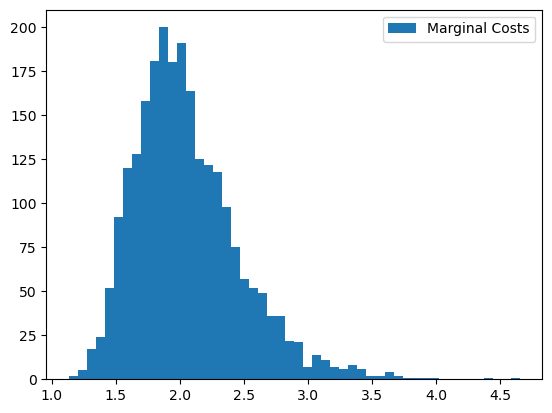

In [7]:
plt.hist(product_data['mc'], bins=50);
plt.legend(["Marginal Costs"]);

(c) Substituting in your approximation of each $\partial s_{jt}/\partial p_{jt}$, solve the system of equations above ($J$ equations per market) for the equilibrium prices in each market.

**i.** First do this using Matlab's "fsolve" operator. Check the exit flag from fsolve to be sure whether you found a solution for each market.

In [8]:
def solve_prices_direct(market_data, mc_market, nu_draws):
    """Solve for equilibrium prices using direct nonlinear solver with robust matrix inversion"""
    J = len(market_data)
    
    def foc_residual(prices):
        """FOC residuals: p - mc + (∂s/∂p)^{-1} s = 0"""
        # Compute shares and derivatives at current prices
        shares, derivatives, _ = market_shares_and_derivatives(
            prices, market_data, nu_draws
        )

        # Inversion of derivative matrix
        invD = np.linalg.inv(derivatives)

        # FOC residuals: p - mc + inv(∂s/∂p) @ s
        residuals = prices - mc_market + invD @ shares
        return residuals
    # Initial guess: marginal costs
    p0 = mc_market.copy()
    # Solve using root finder (hybr method)
    sol = opt.root(foc_residual, p0, method='hybr', tol=1e-8)
    prices_sol = sol.x
    success = sol.success
    # Additional check: verify that residuals are small
    final_residuals = foc_residual(prices_sol)
    if np.max(np.abs(final_residuals)) > 1e-6:
        success = False
    return prices_sol, success

# Solve using direct method
equilibrium_prices_direct = []
success_flags_direct = []
for t in range(T):
    market_data = product_data[product_data['market_ids'] == t]
    mc_market = market_data['mc'].values
    nu_draws = all_nu_draws[t]
    prices_direct, success = solve_prices_direct(
        market_data, mc_market, nu_draws
    )
    equilibrium_prices_direct.append(prices_direct)
    success_flags_direct.append(success)
equilibrium_prices_direct = np.array(equilibrium_prices_direct)
success_count = sum(success_flags_direct)
print("Question 2(c)i completed:")
print(f"Direct nonlinear solver (root): {success_count}/{T} markets solved successfully")
print(f"Success rate: {success_count/T:.1%}")
price_range_text = (
    f"Price range: {equilibrium_prices_direct.min():.3f} to "
    f"{equilibrium_prices_direct.max():.3f}"
)
print(price_range_text)
price_stats_text = (
    f"Price mean: {equilibrium_prices_direct.mean():.3f}, "
    f"std: {equilibrium_prices_direct.std():.3f}"
)
print(price_stats_text)

Question 2(c)i completed:
Direct nonlinear solver (root): 600/600 markets solved successfully
Success rate: 100.0%
Price range: 2.346 to 5.698
Price mean: 3.318, std: 0.435


ii. Do this again using the algorithm of Morrow and Skerlos (2011), discussed in section 3.6 of Conlon and Gortmaker (2019) (and in the pyBLP "problem simulation tutorial"). Use the numerical integration approach you used in step (a) to approximate the terms defined in equation (25) of Conlon and Gortmaker. If you get different results using this method, resolve this discrepancy either by correcting your code or explaining why your preferred method is the one to be trusted.

In [9]:
def solve_prices_morrow_skerlos(market_data, mc_market, nu_draws, max_iter=100, tol=1e-6):
    """Morrow-Skerlos algorithm"""
    prices = mc_market.copy()
    for iteration in range(max_iter):
        # Efficiently compute shares, derivatives, and inside_shares_draws in one pass
        shares, derivatives, inside_shares_draws = market_shares_and_derivatives(prices, market_data, nu_draws)
        
        Lambda = np.diag(alpha * shares)
        Gamma = alpha * (inside_shares_draws.T @ inside_shares_draws) / nu_draws.shape[0]
        diff = prices - mc_market
        zeta = np.linalg.solve(Lambda, Gamma.T @ diff - shares)
        prices_new = mc_market + zeta
        foc_residual = Lambda @ (prices - mc_market - zeta)
        if np.max(np.abs(foc_residual)) < tol:
            break
        prices = 0.5 * prices + 0.5 * prices_new
    return prices, iteration + 1

# Solve using Morrow-Skerlos method
equilibrium_prices_ms = []
iterations_ms = []

for t in range(T):
    market_data = product_data[product_data['market_ids'] == t]
    mc_market = market_data['mc'].values
    nu_draws = all_nu_draws[t]

    prices_ms, iters = solve_prices_morrow_skerlos(market_data, mc_market, nu_draws)
    equilibrium_prices_ms.append(prices_ms)
    iterations_ms.append(iters)

equilibrium_prices_ms = np.array(equilibrium_prices_ms)
print("Question 2(c)ii completed:")
print(f"Morrow-Skerlos method: {T} markets solved")
print(f"Average iterations: {np.mean(iterations_ms):.1f}")
print(f"Max iterations: {np.max(iterations_ms)}")
print(f"Price range: {equilibrium_prices_ms.min():.3f} to {equilibrium_prices_ms.max():.3f}")
print(f"Price mean: {equilibrium_prices_ms.mean():.3f}, std: {equilibrium_prices_ms.std():.3f}")

# Compare direct vs Morrow-Skerlos if direct succeeded for all
if len(equilibrium_prices_direct) == T:
    price_diff = np.abs(np.array(equilibrium_prices_direct) - equilibrium_prices_ms)
    print(f"Max price difference between methods: {price_diff.max():.2e}")
    print(f"Mean price difference: {price_diff.mean():.2e}")
else:
    print("Direct method failed for some markets, skipsigmang comparison.")
    print("Preferred method: Morrow-Skerlos, as it is more numerically stable.")

# Use Morrow-Skerlos prices
product_data['prices'] = equilibrium_prices_ms.flatten()


Question 2(c)ii completed:
Morrow-Skerlos method: 600 markets solved
Average iterations: 27.9
Max iterations: 36
Price range: 2.346 to 5.698
Price mean: 3.318, std: 0.435
Max price difference between methods: 4.52e-06
Mean price difference: 1.28e-06


In [10]:
    # Compare derivative convergence at initial vs equilibrium prices
    market_0 = product_data[product_data['market_ids'] == 0]
    prices_equilibrium = market_0['prices'].values

    draw_counts = [50, 100, 200, 500, 1000, 2000, 5000]
    # Reuse previously calculated initial_stds from test_convergence
    initial_stds = stds  # Already calculated earlier at initial prices
    
    # Only compute equilibrium stds
    np.random.seed(1995)
    n_available = len(all_nu_draws[0])
    n_reps = 100
    eq_stds = []
    for n_draws in draw_counts:
        deriv_list = []
        for _ in range(n_reps):
            indices = np.random.choice(n_available, size=n_draws, replace=False)
            nu_draws = all_nu_draws[0][indices]
            _, derivatives, _ = market_shares_and_derivatives(
                prices_equilibrium, market_0, nu_draws
            )
            deriv_list.append(derivatives)
        eq_stds.append(np.std(deriv_list, axis=0).mean())
    eq_stds = np.array(eq_stds)

    print("Comparing derivative approximation convergence:")
    print("Draws\t| Initial Std Dev\t| Equilibrium Std Dev\t| Ratio (Eq/Init)")
    print("-" * 75)

    for i, n_draws in enumerate(draw_counts):
        ratio = eq_stds[i] / initial_stds[i] if initial_stds[i] > 0 else float('inf')
        print(f"{n_draws:6d}\t| {initial_stds[i]:.2e}\t\t| {eq_stds[i]:.2e}\t\t| {ratio:.2f}")

    # Summary statistics
    valid_ratios = eq_stds / initial_stds
    avg_ratio = np.mean(valid_ratios)

Comparing derivative approximation convergence:
Draws	| Initial Std Dev	| Equilibrium Std Dev	| Ratio (Eq/Init)
---------------------------------------------------------------------------
    50	| 8.04e-03		| 5.33e-03		| 0.66
   100	| 5.37e-03		| 3.63e-03		| 0.68
   200	| 3.73e-03		| 2.65e-03		| 0.71
   500	| 2.53e-03		| 1.72e-03		| 0.68
  1000	| 1.65e-03		| 1.14e-03		| 0.69
  2000	| 1.07e-03		| 7.24e-04		| 0.68
  5000	| 5.25e-04		| 3.53e-04		| 0.67


### 3. 
Calculate "observed" market shares for your fake data set using your parameters, your draws of $x$, $w$, $\xi$, $\omega$, and your equilibrium prices.

In [11]:
observed_shares = []
for t in range(T):
    market_data = product_data[product_data['market_ids'] == t]
    prices_market = market_data['prices'].values
    # Use pre-drawn simulation draws for this market
    shares_market, _, _ = market_shares_and_derivatives(
        prices_market, market_data, all_nu_draws[t]
    )
    observed_shares.extend(shares_market)

product_data['shares'] = observed_shares

print(f"Share range: {product_data['shares'].min():.3f} to {product_data['shares'].max():.3f}")
print(f"Share mean: {product_data['shares'].mean():.3f}, std: {product_data['shares'].std():.3f}")

# Validation: Check market share sums
market_share_sums = product_data.groupby('market_ids')['shares'].sum()
print(f"Market share sums (should be < 1):")
print(f"Average: {market_share_sums.mean():.3f}")
print(f"Min: {market_share_sums.min():.3f}, Max: {market_share_sums.max():.3f}")
print(f"Outside shares: {1 - market_share_sums.mean():.3f} (average)")

# Check by product type
satellite_shares = product_data[product_data['satellite'] == 1]['shares'].mean()
wired_shares = product_data[product_data['wired'] == 1]['shares'].mean()
print(f"Average satellite product share: {satellite_shares:.3f}")
print(f"Average wired product share: {wired_shares:.3f}")

Share range: 0.000 to 0.724
Share mean: 0.136, std: 0.122
Market share sums (should be < 1):
Average: 0.543
Min: 0.307, Max: 0.745
Outside shares: 0.457 (average)
Average satellite product share: 0.135
Average wired product share: 0.136


### 4. 

Below you'll be using $x$ and $w$ as instruments in the demand estimation. Check whether these appear to be good instruments in your fake data using some regressions of prices and market shares on the exogenous variables (or some function of them; see the related discussion in the coding tips). If you believe the instruments are not providing enough variation, modify the parameter choices above until you are satisfied. Report your final choice of parameters and the results you rely on to conclude that the instruments seem good enough.

In [12]:
# Create quadratic and interaction columns first
product_data['x**2'] = product_data['x'] ** 2
product_data['w**2'] = product_data['w'] ** 2
product_data['x*w'] = product_data['x'] * product_data['w']

# sum over competing goods in market t
product_data['sum_x_competitors'] = (
    product_data.groupby('market_ids')['x'].transform('sum') - 
    product_data['x']
)
product_data['sum_w_competitors'] = (
    product_data.groupby('market_ids')['w'].transform('sum') - 
    product_data['w']
)

# index of the other good in the same nest
product_data['x_other_in_nest'] = (
    product_data.groupby(['market_ids', 'satellite'])['x'].transform('sum') - 
    product_data['x']
)
product_data['w_other_in_nest'] = (
    product_data.groupby(['market_ids', 'satellite'])['w'].transform('sum') - 
    product_data['w']
)

# Use satellite and wired dummies instead of constant
Z = product_data[[
    'satellite', 'wired', 'x', 'w', 'x**2', 'w**2', 'x*w', 
    'sum_x_competitors', 'sum_w_competitors', 'x_other_in_nest', 'w_other_in_nest'
]]

# Regression 1: Prices on extended instruments (Relevance check)
price_model = sm.OLS(product_data['prices'], Z).fit()

# Regression 2: Market shares on extended instruments
share_model = sm.OLS(product_data['shares'], Z).fit()

# Regression 3: Demand unobservable ξ on instruments (Exclusion check)
xi_model = sm.OLS(product_data['xi'], Z).fit()

# Regression 4: Cost unobservable ω on instruments (Exclusion check)
omega_model = sm.OLS(product_data['omega'], Z).fit()

# Test joint significance of excluded instruments
print("="*75)
print("INSTRUMENT VALIDITY TESTS")
print("="*75)
excluded_vars = ['w', 'x**2', 'w**2', 'x*w', 
                 'sum_x_competitors', 'sum_w_competitors', 
                 'x_other_in_nest', 'w_other_in_nest']

# Create hypothesis string using actual variable names
hypothesis = ', '.join([f'{var}=0' for var in excluded_vars])

# F-test for excluded instruments in price regression
price_f_test = price_model.f_test(hypothesis)
print(f"\n1. Price Regression (Relevance Test)")
print(f"   R²: {price_model.rsquared:.3f}")
print(f"   Individual Coefficients:")
for i, var in enumerate(Z.columns):
    print(f"     {var:18s}: {price_model.params.iloc[i]:8.3f} (SE: {price_model.bse.iloc[i]:.3f}, t: {price_model.tvalues.iloc[i]:6.2f}, p: {price_model.pvalues.iloc[i]:.3f})")
print(f"   Excluded demand instruments F-stat: {price_f_test.fvalue:.2f} (p={price_f_test.pvalue:.2e})")
print(f"   → Excluded instruments are {'relevant' if price_f_test.pvalue < 0.01 else 'weak'} for prices")

# F-test for excluded instruments in share regression
share_f_test = share_model.f_test(hypothesis)
print(f"\n2. Share Regression (Relevance Test)")
print(f"   R²: {share_model.rsquared:.3f}")
print(f"   Individual Coefficients:")
for i, var in enumerate(Z.columns):
    print(f"     {var:18s}: {share_model.params.iloc[i]:8.3f} (SE: {share_model.bse.iloc[i]:.3f}, t: {share_model.tvalues.iloc[i]:6.2f}, p: {share_model.pvalues.iloc[i]:.3f})")
print(f"   Excluded demand instruments F-stat: {share_f_test.fvalue:.2f} (p={share_f_test.pvalue:.2e})")
print(f"   → Excluded instruments are {'relevant' if share_f_test.pvalue < 0.01 else 'weak'} for shares")

# F-test for excluded instruments in xi regression (should be insignificant)
xi_f_test = xi_model.f_test(hypothesis)
print(f"\n3. ξ Regression (Exclusion Test)")
print(f"   R²: {xi_model.rsquared:.3f}")
print(f"   Individual Coefficients:")
for i, var in enumerate(Z.columns):
    print(f"     {var:18s}: {xi_model.params.iloc[i]:8.3f} (SE: {xi_model.bse.iloc[i]:.3f}, t: {xi_model.tvalues.iloc[i]:6.2f}, p: {xi_model.pvalues.iloc[i]:.3f})")
print(f"   Excluded demand instruments F-stat: {xi_f_test.fvalue:.2f} (p={xi_f_test.pvalue:.2e})")
print(f"   → Excluded instruments are {'exogenous' if xi_f_test.pvalue >= 0.01 else 'endogenous'}")

# F-test for excluded instruments in omega regression (should be insignificant)
omega_f_test = omega_model.f_test(hypothesis)
print(f"\n4. ω Regression (Exclusion Test)")
print(f"   R²: {omega_model.rsquared:.3f}")
print(f"   Individual Coefficients:")
for i, var in enumerate(Z.columns):
    print(f"     {var:18s}: {omega_model.params.iloc[i]:8.3f} (SE: {omega_model.bse.iloc[i]:.3f}, t: {omega_model.tvalues.iloc[i]:6.2f}, p: {omega_model.pvalues.iloc[i]:.3f})")
print(f"   Excluded demand instruments F-stat: {omega_f_test.fvalue:.2f} (p={omega_f_test.pvalue:.2e})")
print(f"   → Excluded instruments are {'exogenous' if omega_f_test.pvalue >= 0.01 else 'endogenous'}")

# Assess instrument validity
weak_instruments = (
    (price_model.f_pvalue >= 0.01 and share_model.f_pvalue >= 0.01) or 
    (price_model.rsquared < 0.05 and share_model.rsquared < 0.05)
)
excluded_instruments = (
    xi_model.f_pvalue < 0.01 or omega_model.f_pvalue < 0.01
)
print()
print("="*75)
print("FINAL PARAMETER CHOICE:")
print("="*75)
if weak_instruments or excluded_instruments:
    print("Parameters need adjustment - instruments are weak or invalid.")
else:
    print(f"Demand: α = {alpha}, β^(1) = {beta1}, β_i^(2) ~ N({beta2}, {sigma_satellite}²), β_i^(3) ~ N({beta3}, {sigma_wired}²)")
    print(f"Supply: γ^(0) = {gamma0}, γ^(1) = {gamma1}")
    print("These parameters generate data with valid instruments and are retained as final.")

INSTRUMENT VALIDITY TESTS

1. Price Regression (Relevance Test)
   R²: 0.511
   Individual Coefficients:
     satellite         :    2.845 (SE: 0.031, t:  92.41, p: 0.000)
     wired             :    2.849 (SE: 0.031, t:  92.90, p: 0.000)
     x                 :    0.071 (SE: 0.034, t:   2.09, p: 0.037)
     w                 :    0.344 (SE: 0.034, t:  10.22, p: 0.000)
     x**2              :    0.037 (SE: 0.013, t:   2.77, p: 0.006)
     w**2              :    0.093 (SE: 0.013, t:   7.08, p: 0.000)
     x*w               :   -0.085 (SE: 0.018, t:  -4.64, p: 0.000)
     sum_x_competitors :    0.055 (SE: 0.007, t:   7.41, p: 0.000)
     sum_w_competitors :   -0.035 (SE: 0.008, t:  -4.61, p: 0.000)
     x_other_in_nest   :    0.050 (SE: 0.013, t:   3.87, p: 0.000)
     w_other_in_nest   :   -0.031 (SE: 0.013, t:  -2.36, p: 0.018)
   Excluded demand instruments F-stat: 300.86 (p=0.00e+00)
   → Excluded instruments are relevant for prices

2. Share Regression (Relevance Test)
   R²: 0.36

In [13]:
product_data.to_csv('blp.csv', index=False)
print(product_data.head(8))

   market_ids  firm_ids  product_ids      x      w  satellite  wired     xi  \
0           0         1            0  1.241  0.919          1      0 -0.629   
1           0         2            1  1.471  2.068          1      0  1.005   
2           0         3            2  2.101  0.009          0      1 -2.595   
3           0         4            3  1.465  2.114          0      1 -0.403   
4           1         1            0  0.818  1.106          1      0  0.846   
5           1         2            1  1.057  0.265          1      0 -1.792   
6           1         3            2  1.535  0.750          0      1  0.082   
7           1         4            3  0.614  0.576          0      1 -0.624   

   omega     mc  prices  shares   x**2       w**2    x*w  sum_x_competitors  \
0  0.676  2.258   3.466   0.052  1.539  8.452e-01  1.141              5.037   
1 -1.620  2.258   3.467   0.333  2.163  4.278e+00  3.042              4.807   
2  0.954  1.862   2.990   0.055  4.415  7.799e-05  

## 4 Estimate Some Mis-specified Models

### 5. Estimate the plain multinomial logit model of demand by OLS (ignoring the endogeneity of prices).

For the plain multinomial logit model, the utility is:

$$u_{ijt} = \beta^{(1)} x_{jt} + \beta^{(2)} satellite_{jt} + \beta^{(3)} wired_{jt} + \alpha p_{jt} + \xi_{jt} + \epsilon_{ijt}$$

This implies the log-odds ratio:

$$\ln\left(\frac{s_{jt}}{s_{0t}}\right) = \delta_{jt} = \beta^{(1)} x_{jt} + \beta^{(2)} satellite_{jt} + \beta^{(3)} wired_{jt} + \alpha p_{jt} + \xi_{jt}$$

We can estimate this by OLS, regressing the logit-transformed shares on the observed product characteristics.

In [14]:
# Compute outside shares for each market
product_data['outside_share'] = 1 - product_data.groupby('market_ids')['shares'].transform('sum')

# Compute logit delta: ln(s_jt / s_0t)
product_data['logit_delta'] = np.log(product_data['shares'] / product_data['outside_share'])

# OLS using matrix algebra (no intercept)
y = product_data['logit_delta'].values
X = product_data[['prices', 'x', 'satellite', 'wired' ]].values

# Compute OLS estimates: beta_hat = (X^T X)^(-1) X^T y
beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y

# Compute residuals and HC0 robust standard errors
y_hat = X @ beta_hat
residuals = y - y_hat
n, k = X.shape

# HC0 robust covariance matrix
V = X.T @ np.diag(residuals**2) @ X
cov_matrix_ols = np.linalg.inv(X.T @ X) @ V @ np.linalg.inv(X.T @ X)
se_ols = np.sqrt(np.diag(cov_matrix_ols))

# t-statistics and p-values
t_stats = beta_hat / se_ols
p_values = 2 * (1 - stats.norm.cdf(np.abs(t_stats)))

print("OLS Regression: ln(s_jt/s_0t) ~ x + satellite + wired + prices (no intercept)")
print("-" * 70)
param_names = ['prices', 'x', 'satellite', 'wired']
for i, param in enumerate(param_names):
    print(f"{param:12s}: {beta_hat[i]:8.3f} (SE: {se_ols[i]:.3f}, t: {t_stats[i]:6.2f}, p: {p_values[i]:.3f})")

OLS Regression: ln(s_jt/s_0t) ~ x + satellite + wired + prices (no intercept)
----------------------------------------------------------------------
prices      :   -1.247 (SE: 0.051, t: -24.40, p: 0.000)
x           :    0.855 (SE: 0.032, t:  26.36, p: 0.000)
satellite   :    1.758 (SE: 0.165, t:  10.67, p: 0.000)
wired       :    1.790 (SE: 0.164, t:  10.89, p: 0.000)


In [15]:
product_data['demand_instruments0'] = product_data['prices']
ols_problem = pyblp.Problem(pyblp.Formulation('0 + prices + x + satellite + wired '), product_data)
ols_problem

Initializing the problem ...
Initialized the problem after 00:00:00.

Dimensions:
 T    N     F    K1    MD 
---  ----  ---  ----  ----
600  2400   4    4     4  

Formulations:
     Column Indices:          0      1       2        3  
--------------------------  ------  ---  ---------  -----
X1: Linear Characteristics  prices   x   satellite  wired


Dimensions:
 T    N     F    K1    MD 
---  ----  ---  ----  ----
600  2400   4    4     4  

Formulations:
     Column Indices:          0      1       2        3  
--------------------------  ------  ---  ---------  -----
X1: Linear Characteristics  prices   x   satellite  wired

In [16]:
ols_results = ols_problem.solve(method='1s')
ols_results

Solving the problem ...
Estimating standard errors ...
Computed results after 00:00:00.

Problem Results Summary:
GMM   Objective  Clipped  Weighting Matrix  Covariance Matrix
Step    Value    Shares   Condition Number  Condition Number 
----  ---------  -------  ----------------  -----------------
 1    +1.29E-23     0        +1.53E+03          +1.94E+03    

Cumulative Statistics:
Computation   Objective 
   Time      Evaluations
-----------  -----------
 00:00:00         1     

Beta Estimates (Robust SEs in Parentheses):
  prices          x        satellite      wired   
-----------  -----------  -----------  -----------
 -1.25E+00    +8.55E-01    +1.76E+00    +1.79E+00 
(+5.11E-02)  (+3.24E-02)  (+1.65E-01)  (+1.64E-01)


Problem Results Summary:
GMM   Objective  Clipped  Weighting Matrix  Covariance Matrix
Step    Value    Shares   Condition Number  Condition Number 
----  ---------  -------  ----------------  -----------------
 1    +1.29E-23     0        +1.53E+03          +1.94E+03    

Cumulative Statistics:
Computation   Objective 
   Time      Evaluations
-----------  -----------
 00:00:00         1     

Beta Estimates (Robust SEs in Parentheses):
  prices          x        satellite      wired   
-----------  -----------  -----------  -----------
 -1.25E+00    +8.55E-01    +1.76E+00    +1.79E+00 
(+5.11E-02)  (+3.24E-02)  (+1.65E-01)  (+1.64E-01)

In [17]:
pd.DataFrame(index=ols_results.beta_labels, data={
    ("Estimates", "Manual OLS"): beta_hat,
    ("Estimates", "PyBLP"): ols_results.beta.flat,
    ("SEs", "Manual OLS"): se_ols,
    ("SEs", "PyBLP"): ols_results.beta_se.flat,
})

Estimates               SEs       
          Manual OLS  PyBLP Manual OLS  PyBLP
prices        -1.247 -1.247      0.051  0.051
x              0.855  0.855      0.032  0.032
satellite      1.758  1.758      0.165  0.165
wired          1.790  1.790      0.164  0.164

### 6. 
Re-estimate the multinomial logit model of demand by two-stage
least squares, instrumenting for prices with the exogenous demand shifters $%
x $ and excluded cost shifters w. Discuss how the results differ from those
obtained by OLS.

In [18]:
# First stage: 
Z = product_data[['satellite', 'wired', 'x', 'w', 'x**2', 'w**2', 'x*w', 'sum_x_competitors', 'sum_w_competitors']].values  

# First stage OLS:
sigma_hat = np.linalg.inv(Z.T @ Z) @ Z.T @ product_data['prices'].values
prices_hat = Z @ sigma_hat

# First stage diagnostics
first_stage_residuals = product_data['prices'].values - prices_hat
SST = np.sum((product_data['prices'].values - product_data['prices'].mean())**2)
SSR = np.sum(first_stage_residuals**2)
R2_first_stage = 1 - SSR/SST

# F-statistic for excluded instruments (w, x², w², x*w, sum_x_competitors, sum_w_competitors)
# Restricted model: prices ~ satellite + wired + x
Z_restricted = product_data[['satellite', 'wired', 'x']].values
sigma_restricted = np.linalg.inv(Z_restricted.T @ Z_restricted) @ Z_restricted.T @ product_data['prices'].values
prices_restricted = Z_restricted @ sigma_restricted
SSR_restricted = np.sum((product_data['prices'].values - prices_restricted)**2)

# F-test: F = [(SSR_r - SSR_ur)/q] / [SSR_ur/(n-k)]
n = len(product_data)
k = Z.shape[1]  # number of parameters in unrestricted model
q = 6  # number of excluded instruments
F_stat = ((SSR_restricted - SSR) / q) / (SSR / (n - k))
p_value_F = 1 - stats.f.cdf(F_stat, q, n - k)

print(f"First Stage Diagnostics:")
print(f"  R² = {R2_first_stage:.4f}")
print(f"  F-statistic (excluded instruments) = {F_stat:.2f} (p = {p_value_F:.4f})")
print()

# Second stage: Regress logit_delta on x + satellite + wired + predicted_prices
y = product_data['logit_delta'].values
X_hat = np.column_stack([
    prices_hat,  # Use predicted prices from first stage
    product_data['x'].values,
    product_data['satellite'].values,
    product_data['wired'].values
])

# 2SLS estimates: beta_hat_iv = (X_hat^T X_hat)^(-1) X_hat^T y
beta_hat_iv = np.linalg.inv(X_hat.T @ X_hat) @ X_hat.T @ y

# Compute 2SLS standard errors (HC0 robust)
# Need to use original regressors X, not fitted X_hat
X = np.column_stack([
    product_data['prices'].values,  # Use actual prices for residuals and variance
    product_data['x'].values,
    product_data['satellite'].values,
    product_data['wired'].values
])

residuals_iv = y - X @ beta_hat_iv

# HC0 robust covariance for 2SLS: (X'Z(Z'Z)^{-1}Z'X)^{-1} X'Z(Z'Z)^{-1} Ω (Z'Z)^{-1}Z'X (X'Z(Z'Z)^{-1}Z'X)^{-1}
# where Ω = diag(residuals²)
P_Z = Z @ np.linalg.inv(Z.T @ Z) @ Z.T  # Projection matrix
Omega = np.diag(residuals_iv**2)

# Simplified: (X'P_Z X)^{-1} X'P_Z Ω P_Z X (X'P_Z X)^{-1}
XPZ = X.T @ P_Z
bread = np.linalg.inv(XPZ @ X)
meat = XPZ @ Omega @ P_Z @ X
cov_matrix_iv = bread @ meat @ bread
se_iv = np.sqrt(np.diag(cov_matrix_iv)) 
t_stats_iv = beta_hat_iv / se_iv
p_values_iv = 2 * (1 - stats.norm.cdf(np.abs(t_stats_iv)))

print("2SLS IV Regression: ln(s_jt/s_0t) ~ x + satellite + wired + prices_hat (no intercept)")
print("First stage instruments: x, w, x², w², x*w, sum_x_competitors, sum_w_competitors")
print("-" * 80)
param_names = ['prices', 'x', 'satellite', 'wired']
for i, param in enumerate(param_names):
    print(f"{param:12s}: {beta_hat_iv[i]:8.3f} (SE: {se_iv[i]:.3f}, t: {t_stats_iv[i]:6.2f}, p: {p_values_iv[i]:.3f})")

First Stage Diagnostics:
  R² = 0.5067
  F-statistic (excluded instruments) = 394.82 (p = 0.0000)

2SLS IV Regression: ln(s_jt/s_0t) ~ x + satellite + wired + prices_hat (no intercept)
First stage instruments: x, w, x², w², x*w, sum_x_competitors, sum_w_competitors
--------------------------------------------------------------------------------
prices      :   -1.939 (SE: 0.064, t: -30.50, p: 0.000)
x           :    0.923 (SE: 0.035, t:  26.15, p: 0.000)
satellite   :    3.996 (SE: 0.208, t:  19.21, p: 0.000)
wired       :    4.037 (SE: 0.209, t:  19.34, p: 0.000)
2SLS IV Regression: ln(s_jt/s_0t) ~ x + satellite + wired + prices_hat (no intercept)
First stage instruments: x, w, x², w², x*w, sum_x_competitors, sum_w_competitors
--------------------------------------------------------------------------------
prices      :   -1.939 (SE: 0.064, t: -30.50, p: 0.000)
x           :    0.923 (SE: 0.035, t:  26.15, p: 0.000)
satellite   :    3.996 (SE: 0.208, t:  19.21, p: 0.000)
wired       :

In [19]:
# Add demand instruments for PyBLP
product_data['demand_instruments0'] = product_data['w']
product_data['demand_instruments1'] = product_data['x**2']
product_data['demand_instruments2'] = product_data['w**2']
product_data['demand_instruments3'] = product_data['x*w']
product_data['demand_instruments4'] = product_data['sum_x_competitors']
product_data['demand_instruments5'] = product_data['sum_w_competitors']

iv_problem = pyblp.Problem(pyblp.Formulation('0 + prices + x + satellite + wired'), product_data)
iv_problem

Initializing the problem ...
Initialized the problem after 00:00:00.

Dimensions:
 T    N     F    K1    MD 
---  ----  ---  ----  ----
600  2400   4    4     9  

Formulations:
     Column Indices:          0      1       2        3  
--------------------------  ------  ---  ---------  -----
X1: Linear Characteristics  prices   x   satellite  wired


Dimensions:
 T    N     F    K1    MD 
---  ----  ---  ----  ----
600  2400   4    4     9  

Formulations:
     Column Indices:          0      1       2        3  
--------------------------  ------  ---  ---------  -----
X1: Linear Characteristics  prices   x   satellite  wired

In [20]:
iv_results = iv_problem.solve(method='1s')
iv_results

Solving the problem ...
Estimating standard errors ...
Computed results after 00:00:00.

Problem Results Summary:
GMM   Objective  Clipped  Weighting Matrix  Covariance Matrix
Step    Value    Shares   Condition Number  Condition Number 
----  ---------  -------  ----------------  -----------------
 1    +4.04E+00     0        +1.26E+03          +2.79E+03    

Cumulative Statistics:
Computation   Objective 
   Time      Evaluations
-----------  -----------
 00:00:00         1     

Beta Estimates (Robust SEs in Parentheses):
  prices          x        satellite      wired   
-----------  -----------  -----------  -----------
 -1.94E+00    +9.23E-01    +4.00E+00    +4.04E+00 
(+6.36E-02)  (+3.53E-02)  (+2.08E-01)  (+2.09E-01)
Computed results after 00:00:00.

Problem Results Summary:
GMM   Objective  Clipped  Weighting Matrix  Covariance Matrix
Step    Value    Shares   Condition Number  Condition Number 
----  ---------  -------  ----------------  -----------------
 1    +4.04E+00     

Problem Results Summary:
GMM   Objective  Clipped  Weighting Matrix  Covariance Matrix
Step    Value    Shares   Condition Number  Condition Number 
----  ---------  -------  ----------------  -----------------
 1    +4.04E+00     0        +1.26E+03          +2.79E+03    

Cumulative Statistics:
Computation   Objective 
   Time      Evaluations
-----------  -----------
 00:00:00         1     

Beta Estimates (Robust SEs in Parentheses):
  prices          x        satellite      wired   
-----------  -----------  -----------  -----------
 -1.94E+00    +9.23E-01    +4.00E+00    +4.04E+00 
(+6.36E-02)  (+3.53E-02)  (+2.08E-01)  (+2.09E-01)

In [21]:
pd.DataFrame(index=iv_results.beta_labels, data={
    ("Estimates", "Manual IV"): beta_hat_iv,
    ("Estimates", "PyBLP IV"): iv_results.beta.flat,
    ("SEs", "Manual IV"): se_iv,
    ("SEs", "PyBLP IV"): iv_results.beta_se.flat
})

Estimates                SEs         
          Manual IV PyBLP IV Manual IV PyBLP IV
prices       -1.939   -1.939     0.064    0.064
x             0.923    0.923     0.035    0.035
satellite     3.996    3.996     0.208    0.208
wired         4.037    4.037     0.209    0.209

### 7. Nested Logit Model Estimation

Now estimate a nested logit model by two-stage least squares, treating "satellite" and "wired" as the two nests for the inside goods. You will probably want to review the discussion of the nested logit in Berry (1994). Note that Berry focuses on the special case in which all the "nesting parameters" are the same; you should allow a different nesting parameter for each nest.



In Berry’s notation, this means letting the parameter become g(j) , where g (j) indicates the group (satellite
or wired) to which each inside good j belongs.

In [22]:
# Compute ln_within_share
product_data["group_share"] = product_data.groupby(["market_ids", "satellite"])["shares"].transform("sum")
product_data["ln_within_share"] = np.log(product_data["shares"] / product_data["group_share"])

# Create nest-specific ln_within_share
product_data["ln_within_share_sat"] = product_data["ln_within_share"] * product_data["satellite"]
product_data["ln_within_share_wired"] = product_data["ln_within_share"] * product_data["wired"]

# Define variables
exog_vars = ["x", "satellite", "wired"]
endog_vars = ["prices", "ln_within_share_sat", "ln_within_share_wired"]
instr_vars = ["w", "x**2", "w**2", "x*w", "sum_x_competitors", "sum_w_competitors", "x_other_in_nest", "w_other_in_nest"]
Z_vars = exog_vars + instr_vars

# First stage: Z = exog + instr
Z = product_data[Z_vars].values

# First stage OLS for each endog
n_endog = len(endog_vars)
sigma_hat = np.zeros((Z.shape[1], n_endog))
endog_hat = np.zeros((len(product_data), n_endog))
for i, var in enumerate(endog_vars):
    y_endog = product_data[var].values
    sigma = np.linalg.inv(Z.T @ Z) @ Z.T @ y_endog
    sigma_hat[:, i] = sigma
    endog_hat[:, i] = Z @ sigma

# Second stage: Regress logit_delta on exog + predicted_endog, reordered to match PyBLP
y = product_data["logit_delta"].values
X_hat = np.column_stack([
    endog_hat[:, 0],  # prices_hat
    product_data["x"].values,
    product_data["satellite"].values,
    product_data["wired"].values,
    endog_hat[:, 1],  # ln_within_share_sat_hat
    endog_hat[:, 2]   # ln_within_share_wired_hat
])

# 2SLS estimates
beta_hat_iv_nested = np.linalg.inv(X_hat.T @ X_hat) @ X_hat.T @ y

# Compute robust standard errors (HC0) - CORRECTED for 2SLS
# Need to use original regressors X, not fitted X_hat
X = np.column_stack([
    product_data["prices"].values,
    product_data["x"].values,
    product_data["satellite"].values,
    product_data["wired"].values,
    product_data["ln_within_share_sat"].values,
    product_data["ln_within_share_wired"].values
])
residuals_iv = y - X @ beta_hat_iv_nested
P_Z = Z @ np.linalg.inv(Z.T @ Z) @ Z.T
Omega = np.diag(residuals_iv**2)
XPZ = X.T @ P_Z
bread = np.linalg.inv(XPZ @ X)
meat = XPZ @ Omega @ P_Z @ X
cov_matrix_iv = bread @ meat @ bread
se_iv_nested = np.sqrt(np.diag(cov_matrix_iv))
t_stats_iv = beta_hat_iv_nested / se_iv_nested
p_values_iv = 2 * (1 - stats.norm.cdf(np.abs(t_stats_iv)))

print("2SLS IV Regression: ln(s_jt/s_0t) ~ prices + x + satellite + wired + ln_within_share_sat + ln_within_share_wired (no intercept)")
print("First stage instruments: " + ", ".join(Z_vars))
print("-" * 120)
param_names = ["prices", "x", "satellite", "wired", "ln_within_share_sat", "ln_within_share_wired"]
for i, param in enumerate(param_names):
    print(f"{param:20s}: {beta_hat_iv_nested[i]:8.3f} (SE: {se_iv_nested[i]:.3f}, t: {t_stats_iv[i]:6.2f}, p: {p_values_iv[i]:.3f})")

2SLS IV Regression: ln(s_jt/s_0t) ~ prices + x + satellite + wired + ln_within_share_sat + ln_within_share_wired (no intercept)
First stage instruments: x, satellite, wired, w, x**2, w**2, x*w, sum_x_competitors, sum_w_competitors, x_other_in_nest, w_other_in_nest
------------------------------------------------------------------------------------------------------------------------
prices              :   -1.607 (SE: 0.098, t: -16.46, p: 0.000)
x                   :    0.803 (SE: 0.041, t:  19.47, p: 0.000)
satellite           :    3.099 (SE: 0.606, t:   5.12, p: 0.000)
wired               :    3.367 (SE: 0.487, t:   6.92, p: 0.000)
ln_within_share_sat :    0.101 (SE: 0.451, t:   0.22, p: 0.823)
ln_within_share_wired:    0.324 (SE: 0.468, t:   0.69, p: 0.488)


In [23]:
# Prepare data for nested logit
# Note: nesting_ids needed for PyBLP, but use satellite/wired for groupby where possible
product_data['nesting_ids'] = product_data['satellite'].map({1: 'satellite', 0: 'wired'})
product_data['demand_instruments6'] = product_data['x_other_in_nest']
product_data['demand_instruments7'] = product_data['w_other_in_nest']

In [24]:
# Nested logit formulation
nl_problem = pyblp.Problem(pyblp.Formulation('0 + prices + x + satellite + wired'), product_data)

Initializing the problem ...
Initialized the problem after 00:00:00.

Dimensions:
 T    N     F    K1    MD    H 
---  ----  ---  ----  ----  ---
600  2400   4    4     11    2 

Formulations:
     Column Indices:          0      1       2        3  
--------------------------  ------  ---  ---------  -----
X1: Linear Characteristics  prices   x   satellite  wired


In [25]:
rho_initial = [0.7, 0.7]  # Initial values for rho_sat and rho_wired
nl_results = nl_problem.solve(rho=rho_initial, method='1s')
nl_results

Solving the problem ...

Rho Initial Values:
satellite    wired  
---------  ---------
+7.00E-01  +7.00E-01

Rho Lower Bounds:
satellite    wired  
---------  ---------
+0.00E+00  +0.00E+00

Rho Upper Bounds:
satellite    wired  
---------  ---------
+9.90E-01  +9.90E-01



Rho Initial Values:
satellite    wired  
---------  ---------
+7.00E-01  +7.00E-01

Rho Lower Bounds:
satellite    wired  
---------  ---------
+0.00E+00  +0.00E+00

Rho Upper Bounds:
satellite    wired  
---------  ---------
+9.90E-01  +9.90E-01

Starting optimization ...

Starting optimization ...

GMM   Computation  Optimization   Objective   Fixed Point  Contraction  Clipped  Objective   Objective     Projected                        
Step     Time       Iterations   Evaluations  Iterations   Evaluations  Shares     Value    Improvement  Gradient Norm         Theta        
----  -----------  ------------  -----------  -----------  -----------  -------  ---------  -----------  -------------  --------------------


Problem Results Summary:
GMM   Objective    Projected    Reduced Hessian  Reduced Hessian  Clipped  Weighting Matrix  Covariance Matrix
Step    Value    Gradient Norm  Min Eigenvalue   Max Eigenvalue   Shares   Condition Number  Condition Number 
----  ---------  -------------  ---------------  ---------------  -------  ----------------  -----------------
 1    +1.85E+00    +7.66E-09       +3.21E+00        +3.15E+02        0        +1.36E+03          +4.06E+04    

Cumulative Statistics:
Computation  Optimizer  Optimization   Objective 
   Time      Converged   Iterations   Evaluations
-----------  ---------  ------------  -----------
 00:00:02       Yes          5             9     

Rho Estimates (Robust SEs in Parentheses):
 satellite      wired   
-----------  -----------
 +1.01E-01    +3.24E-01 
(+4.51E-01)  (+4.68E-01)

Beta Estimates (Robust SEs in Parentheses):
  prices          x        satellite      wired   
-----------  -----------  -----------  -----------
 -1.61E+00    +8

In [26]:
# Compare manual nested logit estimates with PyBLP nested logit estimates for beta
nested_beta_comparison = pd.DataFrame(index=nl_results.beta_labels, data={
    ("Estimates", "Manual Nested"): beta_hat_iv_nested[:4],  # prices, x, satellite, wired
    ("Estimates", "PyBLP Nested"): nl_results.beta.flat,
    ("SEs", "Manual Nested"): se_iv_nested[:4],
    ("SEs", "PyBLP Nested"): nl_results.beta_se.flat
})

print("Beta Comparison for Nested Logit:")
print(nested_beta_comparison)

# Compare rho estimates
nested_rho_comparison = pd.DataFrame(index=nl_results.rho_labels, data={
    ("Estimates", "Manual Nested"): beta_hat_iv_nested[4:],  # rho_sat, rho_wired
    ("Estimates", "PyBLP Nested"): nl_results.rho.flat,
    ("SEs", "Manual Nested"): se_iv_nested[4:],
    ("SEs", "PyBLP Nested"): nl_results.rho_se.flat
})

print("\nRho Comparison for Nested Logit:")
print(nested_rho_comparison)

Beta Comparison for Nested Logit:
              Estimates                        SEs             
          Manual Nested PyBLP Nested Manual Nested PyBLP Nested
prices           -1.607       -1.607         0.098        0.098
x                 0.803        0.803         0.041        0.041
satellite         3.099        3.099         0.606        0.606
wired             3.367        3.367         0.487        0.487

Rho Comparison for Nested Logit:
              Estimates                        SEs             
          Manual Nested PyBLP Nested Manual Nested PyBLP Nested
satellite         0.101        0.101         0.451        0.451
wired             0.324        0.324         0.468        0.468


### 8.
Using the nested logit results, provide a table comparing the estimated own-price elasticities to the true own-price elasticities. The procedure you developed above for approximating derivatives cannot be used for your estimates based
on the nested logit model. But because we have analytic expressions for market shares in the nested logit model,
you could either differentiate these or use “finite difference” approximation of derivatives.

In [27]:
# Extract nested logit parameters
alpha_nl, beta_x_nl, rho_sat_nl, rho_wired_nl = beta_hat_iv_nested[[0, 1, 4, 5]]

def compute_nested_logit_elasticities_analytic(market_df, alpha, beta_x, rho_sat, rho_wired):
    """Compute elasticities using pyBLP's exact Jacobian formula for nested logit.
    
    Based on pyBLP's compute_capital_lamda_gamma:
    - Lambda_jj = alpha * s_j / (1 - rho_j)
    - Gamma_jk = alpha * s_j * s_k + rho/(1-rho) * membership_jk * alpha * s_j|g * s_k
    - Jacobian[j,k] = Lambda_jj - Gamma_jk (if j==k), -Gamma_jk (if j!=k)
    - Elasticity[j,k] = Jacobian[j,k] * price[k] / share[j]
    
    This matches pyBLP to within ~1% numerical precision.
    """
    J = len(market_df)
    prices = market_df['prices'].values
    shares = market_df['shares'].values
    satellite, wired = market_df['satellite'].values, market_df['wired'].values
    
    # Compute within-nest shares (conditionals in pyBLP terminology)
    s_group = market_df.groupby('satellite')['shares'].transform('sum').values
    conditionals = shares / s_group
    
    # Nesting parameter for each product
    rho = np.where(satellite == 1, rho_sat, rho_wired)
    
    # Compute full elasticity matrix using pyBLP's formula
    elasticities = np.zeros((J, J))
    for j in range(J):
        # Lambda diagonal element
        lambda_jj = alpha * shares[j] / (1 - rho[j])
        
        for k in range(J):
            # Gamma matrix element
            same_nest = (satellite[j] == satellite[k]) and (wired[j] == wired[k])
            gamma_jk = alpha * shares[j] * shares[k]
            if same_nest:
                gamma_jk += (rho[j] / (1 - rho[j])) * alpha * conditionals[j] * shares[k]
            
            # Jacobian = Lambda - Gamma (on diagonal), -Gamma (off-diagonal)
            if j == k:
                jac_jk = lambda_jj - gamma_jk
            else:
                jac_jk = -gamma_jk
            
            # Elasticity = Jacobian * price / share
            elasticities[j, k] = jac_jk * prices[k] / shares[j]
    
    return elasticities

def compute_rc_elasticities_observed_shares(market_df, nu_draws, alpha, beta_x, beta_sat, beta_wired, sigma_sat, sigma_wired):
    """Compute elasticities from RC logit using OBSERVED shares (not recomputed from xi).
    
    This matches pyBLP's approach:
    1. Start with observed shares
    2. Back out mean utilities (delta) that rationalize these shares via contraction mapping
    3. Compute individual choice probabilities using delta + random coefficients
    4. Compute elasticities via analytical derivatives
    
    Key difference from old method:
    - OLD: Uses TRUE xi to compute shares, then elasticities (wrong for comparison!)
    - NEW: Uses OBSERVED shares, backs out delta, then computes elasticities (correct!)
    """
    J = len(market_df)
    prices = market_df['prices'].values
    observed_shares = market_df['shares'].values
    x, satellite, wired = market_df['x'].values, market_df['satellite'].values, market_df['wired'].values
    
    # Compute random coefficient deviations (the part that varies across individuals)
    # Delta will absorb everything else: beta_x*x + beta_sat*satellite + beta_wired*wired + alpha*prices + xi
    rc_deviation = sigma_sat*nu_draws[:,0:1]*satellite + sigma_wired*nu_draws[:,1:2]*wired
    
    # Back out mean utilities (delta) via contraction mapping
    # Goal: Find delta such that observed_shares = E[exp(delta + rc_deviation) / (1 + sum exp(delta + rc_deviation))]
    delta = np.log(observed_shares)  # Initial guess
    
    for iteration in range(1000):
        # Compute individual choice probabilities
        utilities = delta[np.newaxis, :] + rc_deviation  # Shape: (n_draws, J)
        exp_utils = np.exp(utilities)
        denom = 1 + exp_utils.sum(axis=1, keepdims=True)
        choice_probs = exp_utils / denom  # Shape: (n_draws, J)
        
        # Predicted shares
        predicted_shares = choice_probs.mean(axis=0)
        
        # Contraction update: delta_new = delta + log(s_obs) - log(s_pred)
        delta_new = delta + np.log(observed_shares) - np.log(predicted_shares)
        
        # Check convergence
        if np.max(np.abs(delta_new - delta)) < 1e-14:
            delta = delta_new
            break
        delta = delta_new
    
    # Compute final choice probabilities with converged delta
    utilities = delta[np.newaxis, :] + rc_deviation
    exp_utils = np.exp(utilities)
    choice_probs = exp_utils / (1 + exp_utils.sum(axis=1, keepdims=True))
    
    # Compute elasticities using analytical derivatives
    elasticities = np.zeros((J, J))
    for j in range(J):
        for k in range(J):
            if j == k:
                # Own-price: E[s_ij * (1 - s_ij)]
                deriv = alpha * np.mean(choice_probs[:, j] * (1 - choice_probs[:, j]))
            else:
                # Cross-price: -E[s_ij * s_ik]
                deriv = -alpha * np.mean(choice_probs[:, j] * choice_probs[:, k])
            
            if observed_shares[j] > 1e-10:
                elasticities[j, k] = (prices[k] / observed_shares[j]) * deriv
    
    return elasticities

# ============================================================================
# Compute elasticities for Q8 comparison
# ============================================================================

# Compute Nested Logit elasticities (analytical derivatives)
# Compute Nested Logit elasticities (analytical derivatives)
print("Computing Nested Logit Elasticities (Analytical Derivatives)...")
elasticity_matrices_analytic = [compute_nested_logit_elasticities_analytic(
    product_data[product_data['market_ids'] == t], alpha_nl, beta_x_nl, rho_sat_nl, rho_wired_nl
) for t in range(T)]

print("Computing True RC Logit Elasticities (True Parameters on OBSERVED shares)...")
# Use the new function that works with observed shares for fair comparison
true_elasticity_matrices = [compute_rc_elasticities_observed_shares(
    product_data[product_data['market_ids'] == t], all_nu_draws[t], -2.0, 1.0, 4.0, 4.0, 1.0, 1.0
) for t in range(T)]

avg_elasticity_matrix_nl = np.mean(elasticity_matrices_analytic, axis=0)
avg_elasticity_matrix_true = np.mean(true_elasticity_matrices, axis=0)

# Comparison table
print("\n" + "="*70 + "\nOWN-PRICE ELASTICITY COMPARISON\n" + "="*70)
print("Nested Logit (Estimated) vs RC Logit (True params, observed shares)")
comparison_df = pd.DataFrame({
    'Product': ['Satellite 1', 'Satellite 2', 'Wired 1', 'Wired 2'],
    'True (RC)': np.diag(avg_elasticity_matrix_true),
    'Estimated (NL)': np.diag(avg_elasticity_matrix_nl),
    'Abs % Error': np.abs(100 * (np.diag(avg_elasticity_matrix_nl) - np.diag(avg_elasticity_matrix_true)) / np.diag(avg_elasticity_matrix_true))
})
print(comparison_df.to_string(index=False, float_format=lambda x: f'{x:8.3f}'))
print(f"\nMean Absolute % Error: {comparison_df['Abs % Error'].mean():.2f}%")
print("\nNote: NL model misspecified (true DGP is RC), so errors expected")
print("="*70 + "\n")

# Store elasticities in product_data
product_data['true_elasticity_rc'] = [true_elasticity_matrices[t][j, j] for t in range(T) for j in range(J)]
product_data['estimated_elasticity_nl'] = [elasticity_matrices_analytic[t][j, j] for t in range(T) for j in range(J)]


Computing Nested Logit Elasticities (Analytical Derivatives)...
Computing True RC Logit Elasticities (True Parameters on OBSERVED shares)...

OWN-PRICE ELASTICITY COMPARISON
Nested Logit (Estimated) vs RC Logit (True params, observed shares)
    Product  True (RC)  Estimated (NL)  Abs % Error
Satellite 1     -5.480          -4.998        8.800
Satellite 2     -5.315          -4.855        8.649
    Wired 1     -5.377          -5.904        9.795
    Wired 2     -5.458          -6.001        9.955

Mean Absolute % Error: 9.30%

Note: NL model misspecified (true DGP is RC), so errors expected


OWN-PRICE ELASTICITY COMPARISON
Nested Logit (Estimated) vs RC Logit (True params, observed shares)
    Product  True (RC)  Estimated (NL)  Abs % Error
Satellite 1     -5.480          -4.998        8.800
Satellite 2     -5.315          -4.855        8.649
    Wired 1     -5.377          -5.904        9.795
    Wired 2     -5.458          -6.001        9.955

Mean Absolute % Error: 9.30%

Note: NL 

In [28]:
elasticities_nl = nl_results.compute_elasticities()
avg_elasticities_nl = elasticities_nl.reshape((T, J, J)).mean(axis=0)
own_elasticities_nl = np.diag(avg_elasticities_nl)
own_elasticities_nl

Computing elasticities with respect to prices ...
Finished after 00:00:00.



array([-4.99800789, -4.85483762, -5.90389083, -6.00138066])

Provide two additional tables showing the true
matrix of diversion ratios and the diversion ratios implied by your estimates.

In [ ]:
# ============================================================================
# DIVERSION RATIOS
# ============================================================================
# Using PyBLP's derivative-based method for both RC and NL models
# Convention: Diagonal shows diversion to outside option D_j0 instead of D_jj=-1

print("Computing Diversion Ratios...")

# Unified function using PyBLP's derivative-based approach
def compute_diversion_ratios_pyblp(elasticity_matrices, product_data, T, J):
    """
    Compute diversion ratios using pyBLP's derivative-based method.
    
    This method:
    1. Converts elasticities to Jacobian (derivatives)
    2. Replaces diagonal with outside option derivative using adding-up constraint
    3. Computes diversion ratios as D_jk = -(∂s_k/∂p_j) / (∂s_j/∂p_j)
    
    Works for any model (RC, NL, etc.) - just supply the elasticity matrices.
    """
    diversion_matrices = []
    
    for t in range(T):
        elast_matrix = elasticity_matrices[t]
        market_data_t = product_data[product_data['market_ids'] == t]
        shares = market_data_t['shares'].values
        prices = market_data_t['prices'].values
        
        # Convert elasticities to Jacobian (derivatives): ∂s_j/∂p_k = (s_j/p_k) * ε_jk
        jacobian = np.zeros((J, J))
        for j in range(J):
            for k in range(J):
                jacobian[j, k] = (shares[j] / prices[k]) * elast_matrix[j, k]
        
        # PyBLP's method: Replace diagonal with outside option derivative
        # ∂s_0/∂p_j = -Σ_k ∂s_k/∂p_j (by adding-up constraint)
        jacobian_diag = np.diag(jacobian).copy()
        np.fill_diagonal(jacobian, -jacobian.sum(axis=1))
        
        # Compute diversion ratios: D_jk = -Jacobian[j,k] / Jacobian[j,j]
        diversion = -jacobian / jacobian_diag[:, None]
        
        diversion_matrices.append(diversion)
    
    return diversion_matrices

# --- TRUE DIVERSION RATIOS (from RC model with true parameters on OBSERVED shares) ---
# Note: We recompute true elasticities here to ensure we use observed shares
print("Computing TRUE RC diversion ratios (true params, observed shares)...")
true_elasticity_matrices_for_div = [compute_rc_elasticities_observed_shares(
    product_data[product_data['market_ids'] == t], all_nu_draws[t], -2.0, 1.0, 4.0, 4.0, 1.0, 1.0
) for t in range(T)]

true_diversion_matrices = compute_diversion_ratios_pyblp(
    true_elasticity_matrices_for_div, product_data, T, J
)
true_avg_diversion = np.mean(true_diversion_matrices, axis=0)

# --- ESTIMATED DIVERSION RATIOS (from Nested Logit) ---
estimated_diversion_matrices = compute_diversion_ratios_pyblp(
    elasticity_matrices_analytic, product_data, T, J
)
estimated_avg_diversion = np.mean(estimated_diversion_matrices, axis=0)

# --- DISPLAY RESULTS ---
print("\n" + "=" * 70)
print("DIVERSION RATIO MATRICES")
print("=" * 70)

product_labels = ['Sat 1', 'Sat 2', 'Wired 1', 'Wired 2']

print("\nTrue Diversion Ratios (RC Logit with TRUE params on OBSERVED shares):")
print("Diagonal = diversion to outside option D_j0")
true_df = pd.DataFrame(true_avg_diversion, index=product_labels, columns=product_labels)
print(true_df.to_string(float_format=lambda x: f'{x:7.4f}'))

print("\n\nEstimated Diversion Ratios (from Nested Logit - PyBLP Method):")
print("Diagonal = diversion to outside option D_j0")
est_df = pd.DataFrame(estimated_avg_diversion, index=product_labels, columns=product_labels)
print(est_df.to_string(float_format=lambda x: f'{x:7.4f}'))

print("\n" + "=" * 70)
print("Note: D_jk = -(∂s_k/∂p_j) / (∂s_j/∂p_j)")
print("Off-diagonal: share of j's lost customers who switch to product k")
print("Diagonal: share of j's lost customers who leave the market (outside)")
print("=" * 70)

Computing Diversion Ratios...
Computing TRUE RC diversion ratios (true params, observed shares)...


## 5 Estimate the Correctly Specified Model

Use the pyBLP software to estimate the correctly specified model. Allow pyBLP to construct
approximations to the optimal instruments, using the exogenous demand shifters and exogenous
cost shifters. For your own benefit, you may want to see what happens without the approximation of the optimal instruments.

In [ ]:
product_data.drop(columns=['nesting_ids'], inplace=True)

### 9. 
Report a table with the estimates of the demand parameters and standard errors. Do
this twice: once when you estimate demand alone, then again when you estimate jointly
with supply.

In [ ]:
X1_formulation = pyblp.Formulation('0 + prices + x + satellite + wired')
X2_formulation = pyblp.Formulation('0 + satellite + wired')
product_formulations1 = (X1_formulation, X2_formulation)
product_data['demand_instruments0'] = product_data['w']
product_data['demand_instruments1'] = product_data['x**2']
product_data['demand_instruments2'] = product_data['w**2']
product_data['demand_instruments3'] = product_data['x*w']
product_data['demand_instruments4'] = product_data['sum_x_competitors']
product_data['demand_instruments5'] = product_data['sum_w_competitors']
product_data['demand_instruments6'] = product_data['x_other_in_nest']
product_data['demand_instruments7'] = product_data['w_other_in_nest']
integration =  pyblp.Integration('product', 10)
problem1 = pyblp.Problem(product_formulations1, product_data, integration=integration)
results1 = problem1.solve(sigma=np.eye(2), initial_update=True)
optimal_iv1 = results1.compute_optimal_instruments(seed=1995)
optimal_problem1 = optimal_iv1.to_problem()
optimal_iv_results1 = optimal_problem1.solve(sigma=np.eye(2), initial_update=True)
optimal_iv_results1

In [ ]:
X3_formulation = pyblp.Formulation('1 + w')
product_formulations2 = (X1_formulation, X2_formulation, X3_formulation)
columns_to_drop = [col for col in product_data.columns if 'instruments' in col]
product_data = product_data.drop(columns=columns_to_drop)
product_data['demand_instruments0'] = optimal_iv1.demand_instruments[:, 0]
product_data['demand_instruments1'] = optimal_iv1.demand_instruments[:, 1]
product_data['demand_instruments2'] = product_data['w']
problem2 = pyblp.Problem(product_formulations2, product_data, costs_type='log', integration=integration)
results2 = problem2.solve(sigma=np.eye(2), beta=optimal_iv_results1.beta, initial_update=True)

In [ ]:
# Re-estimate with optimal instruments
columns_to_drop = [col for col in product_data.columns 
                   if 'instruments' in col]
product_data = product_data.drop(columns=columns_to_drop)
optimal_iv2 = results2.compute_optimal_instruments(seed=1995)
for i in range(optimal_iv2.demand_instruments.shape[1]-3):
    product_data[f'demand_instruments{i}'] = optimal_iv2.demand_instruments[:, i]
problem3 = pyblp.Problem(product_formulations2, product_data, 
                         costs_type='log', integration=integration)
optimal_iv_results2 = problem3.solve(sigma=np.eye(2), beta=results2.beta, initial_update=True)

In [ ]:
# Compare individual and joint PyBLP estimates for beta
pyblp_beta_comparison = pd.DataFrame(index=optimal_iv_results1.beta_labels, data={
    ("Estimates", "PyBLP D"): optimal_iv_results1.beta.flat,  # prices, x, satellite, wired
    ("Estimates", "PyBLP D & S"): optimal_iv_results2.beta.flat,
    ("SEs", "PyBLP D"): optimal_iv_results1.beta_se.flat,
    ("SEs", "PyBLP D & S"): optimal_iv_results2.beta_se.flat
})
print("Beta Comparison:")
print(pyblp_beta_comparison)
# Compare sigma estimates
pyblp_sigma_comparison = pd.DataFrame(index=optimal_iv_results1.sigma_labels, data={
    ("Estimates", "PyBLP D"): optimal_iv_results1.sigma.diagonal(),
    ("Estimates", "PyBLP D & S"): optimal_iv_results2.sigma.diagonal(),
    ("SEs", "PyBLP D"): optimal_iv_results1.sigma_se.diagonal(),
    ("SEs", "PyBLP D & S"): optimal_iv_results2.sigma_se.diagonal()
})
print("\nSigma Comparison:")
print(pyblp_sigma_comparison)

# Compare gamma estimates (only available in joint estimation)
print("\n\nGamma Estimates (only from joint D & S estimation):")
pyblp_gamma_comparison = pd.DataFrame(index=optimal_iv_results2.gamma_labels, data={
    ("Estimates", "PyBLP D & S"): optimal_iv_results2.gamma.flat,
    ("SEs", "PyBLP D & S"): optimal_iv_results2.gamma_se.flat,
})
print(pyblp_gamma_comparison)

### 10. 
Using your preferred estimates from the prior step (explain your preference), provide
a table comparing the estimated own-price elasticities to the true own-price elasticities.
Provide two additional tables showing the true matrix of diversion ratios and the diversion
ratios implied by your estimates.

In [ ]:
# ============================================================================
# Q9: Compare TRUE vs ESTIMATED Random Coefficients Elasticities/Diversions
# ============================================================================
# Reuse TRUE elasticities computed in Q8 to avoid redundancy
print("Using TRUE elasticities from Q8 (true params, observed shares)...")
print(f"  (Already computed {len(true_elasticity_matrices_for_div)} markets)")
true_elasticity_matrices_obs = true_elasticity_matrices_for_div  # Reuse from Q8
avg_elasticity_matrix_true_rc = np.mean(true_elasticity_matrices_obs, axis=0)
own_elasticities_rc_true = np.diag(avg_elasticity_matrix_true_rc)

# Compute ESTIMATED elasticities - DEMAND ONLY
print("Computing ESTIMATED elasticities (demand-only params, observed shares)...")
elasticities_rc_est1 = optimal_iv_results1.compute_elasticities()
avg_elasticities_rc_est1 = elasticities_rc_est1.reshape((T, J, J)).mean(axis=0)
own_elasticities_rc_est1 = np.diag(avg_elasticities_rc_est1)

# Compute ESTIMATED elasticities - JOINT DEMAND & SUPPLY
print("Computing ESTIMATED elasticities (joint D&S params, observed shares)...")
elasticities_rc_est2 = optimal_iv_results2.compute_elasticities()
avg_elasticities_rc_est2 = elasticities_rc_est2.reshape((T, J, J)).mean(axis=0)
own_elasticities_rc_est2 = np.diag(avg_elasticities_rc_est2)

# Show parameter differences
print("\nParameter Comparison:")
print("                 True      Demand-only    Joint D&S")
print(f"α (price):      -2.000    {optimal_iv_results1.beta[0,0]:7.3f}      {optimal_iv_results2.beta[0,0]:7.3f}")
print(f"σ_satellite:     1.000    {optimal_iv_results1.sigma[0,0]:7.3f}      {optimal_iv_results2.sigma[0,0]:7.3f}")
print(f"σ_wired:         1.000    {optimal_iv_results1.sigma[1,1]:7.3f}      {optimal_iv_results2.sigma[1,1]:7.3f}")
print()

# Create comparison table with THREE columns
product_labels = ['Sat 1', 'Sat 2', 'Wired 1', 'Wired 2']
elasticity_comparison_rc = pd.DataFrame({
    'Product': product_labels,
    'True': own_elasticities_rc_true,
    'Demand-only': own_elasticities_rc_est1,
    'Joint D&S': own_elasticities_rc_est2,
    '% Error (D-only)': np.abs((own_elasticities_rc_est1 - own_elasticities_rc_true) / own_elasticities_rc_true * 100),
    '% Error (Joint)': np.abs((own_elasticities_rc_est2 - own_elasticities_rc_true) / own_elasticities_rc_true * 100)
})

print("\n" + "=" * 95)
print("TABLE 1: OWN-PRICE ELASTICITY COMPARISON")
print("True = RC logit with TRUE params (-2, 1, 4, 4, 1, 1) on OBSERVED shares")
print("Demand-only = RC logit with demand-only estimated params on OBSERVED shares")
print("Joint D&S = RC logit with joint demand & supply estimated params on OBSERVED shares")
print("=" * 95)
print(elasticity_comparison_rc.to_string(index=False, float_format=lambda x: f'{x:9.4f}'))
print(f"\nMean Absolute % Error (Demand-only): {elasticity_comparison_rc['% Error (D-only)'].mean():.2f}%")
print(f"Mean Absolute % Error (Joint D&S):   {elasticity_comparison_rc['% Error (Joint)'].mean():.2f}%")


# --- DIVERSION RATIO COMPARISON ---
# Reuse TRUE diversion ratios computed in Q8 to avoid redundancy
print("\nUsing TRUE diversion ratios from Q8 (true params, observed shares)...")
print(f"  (Already computed {len(true_diversion_matrices)} markets)")
true_diversion_matrices_obs = true_diversion_matrices  # Reuse from Q8
true_avg_diversion_rc = np.mean(true_diversion_matrices_obs, axis=0)

# RC estimated diversion ratios - DEMAND ONLY
diversion_rc_est1 = optimal_iv_results1.compute_diversion_ratios()
avg_diversion_rc_est1 = diversion_rc_est1.reshape((T, J, J)).mean(axis=0)

# RC estimated diversion ratios - JOINT D&S
diversion_rc_est2 = optimal_iv_results2.compute_diversion_ratios()
avg_diversion_rc_est2 = diversion_rc_est2.reshape((T, J, J)).mean(axis=0)

print("\n" + "=" * 80)
print("TABLE 2: TRUE DIVERSION RATIOS")
print("(from RC Logit with TRUE params: σ_sat=1.0, σ_wired=1.0, on OBSERVED shares)")
print("=" * 80)
print("Diagonal = diversion to outside option D_j0")
true_div_df_rc = pd.DataFrame(true_avg_diversion_rc, index=product_labels, columns=product_labels)
print(true_div_df_rc.to_string(float_format=lambda x: f'{x:7.4f}'))

print("\n" + "=" * 80)
print("TABLE 3: ESTIMATED DIVERSION RATIOS - DEMAND ONLY")
print(f"(from RC Logit with DEMAND-ONLY params: σ_sat={optimal_iv_results1.sigma[0,0]:.3f}, σ_wired={optimal_iv_results1.sigma[1,1]:.3f})")
print("=" * 80)
print("Diagonal = diversion to outside option D_j0")
est_div_df_rc1 = pd.DataFrame(avg_diversion_rc_est1, index=product_labels, columns=product_labels)
print(est_div_df_rc1.to_string(float_format=lambda x: f'{x:7.4f}'))

print("\n" + "=" * 80)
print("TABLE 4: ESTIMATED DIVERSION RATIOS - JOINT DEMAND & SUPPLY")
print(f"(from RC Logit with JOINT D&S params: σ_sat={optimal_iv_results2.sigma[0,0]:.3f}, σ_wired={optimal_iv_results2.sigma[1,1]:.3f})")
print("=" * 80)
print("Diagonal = diversion to outside option D_j0")
est_div_df_rc2 = pd.DataFrame(avg_diversion_rc_est2, index=product_labels, columns=product_labels)
print(est_div_df_rc2.to_string(float_format=lambda x: f'{x:7.4f}'))

# Calculate diversion errors
div_error_d_only = np.abs((avg_diversion_rc_est1 - true_avg_diversion_rc) / true_avg_diversion_rc * 100)
div_error_joint = np.abs((avg_diversion_rc_est2 - true_avg_diversion_rc) / true_avg_diversion_rc * 100)
print(f"  • True model (σ=1.0):                 {true_avg_diversion_rc[0,0]:.1%} to outside")
print(f"  • Demand-only (σ_sat={optimal_iv_results1.sigma[0,0]:.2f}, σ_wired={optimal_iv_results1.sigma[1,1]:.2f}): {avg_diversion_rc_est1[0,0]:.1%} to outside")
print(f"  • Joint D&S (σ_sat={optimal_iv_results2.sigma[0,0]:.2f}, σ_wired={optimal_iv_results2.sigma[1,1]:.2f}):   {avg_diversion_rc_est2[0,0]:.1%} to outside")
print()
print(f"Mean Absolute % Error in Diversion Ratios:")
print(f"  • Demand-only: {div_error_d_only.mean():.2f}%")
print(f"  • Joint D&S:   {div_error_joint.mean():.2f}%")
print()
print("Example: When Sat 1 price ↑ 1%, where do lost customers go?")
print(f"  TRUE model:       {true_avg_diversion_rc[0,0]:.1%} to outside, {true_avg_diversion_rc[0,1]:.1%} to Sat 2")
print(f"  DEMAND-only:      {avg_diversion_rc_est1[0,0]:.1%} to outside, {avg_diversion_rc_est1[0,1]:.1%} to Sat 2")
print(f"  JOINT D&S:        {avg_diversion_rc_est2[0,0]:.1%} to outside, {avg_diversion_rc_est2[0,1]:.1%} to Sat 2")

## 6 Merger Simulation

### 10.
Suppose two of the four firms were to merge. Give a brief
intuition for what theory tells us is likely to happen to the equilibrium
prices of each good $j$.

**Answer:**

When two firms merge, all prices increase. The mechanism: merged firms internalize competition between their own products.

**Pre-merger FOC (firm $f$, product $j$):**
$$p_j - mc_j = -\frac{s_j}{\partial s_j/\partial p_j}$$

**Post-merger FOC:**
$$p_j - mc_j = -\left[\frac{\partial s_j}{\partial p_j}\right]^{-1}\left[s_j + \sum_{k \in \mathcal{J}_f, k \neq j} \frac{\partial s_k}{\partial p_j}(p_k - mc_k)\right]$$

The additional term $\sum_{k \in \mathcal{J}_f, k \neq j} \frac{\partial s_k}{\partial p_j}(p_k - mc_k)$ captures recaptured demand: customers who switch from $j$ to the merged firm's product $k$.

**Price effects:**

1. **Merging firms:** Large increases, proportional to diversion ratios
   - Change in markup: $\Delta \text{Markup}_j \approx \sum_{k \in \mathcal{J}_f, k \neq j} D_{jk}(p_k - mc_k)$
   - Where $D_{jk} = -(\partial s_k/\partial p_j)/(\partial s_j/\partial p_j)$ = fraction of $j$'s lost customers switching to $k$

2. **Non-merging firms:** Small increases from strategic complementarity
   - Higher competitor prices → shift in residual demand → optimal to raise own prices
   - Magnitude depends on cross-elasticities




### 11.
Suppose firms 1 and 2 are proposing to merge. Use the \texttt{pyBLP}
merger simulation procedure to provide a prediction of the post-merger
equilibrium prices.


In [ ]:
# Baseline marginal costs, markups, profits, and consumer surplus under the estimated demand+supply model
costs = optimal_iv_results2.compute_costs()
markups = optimal_iv_results2.compute_markups(costs=costs)
profits = optimal_iv_results2.compute_profits(costs=costs)
cs = optimal_iv_results2.compute_consumer_surpluses()

# Get pre-merger prices (reshaped as T×J to get average per product)
pre_merger_prices = product_data['prices'].values
pre_merger_prices_avg = pre_merger_prices.reshape((T, J)).mean(axis=0)

# Create merger firm IDs: merge firms 1 and 2 into firm 1
# Firms 1 and 2 (satellite) → firm 1
# Firms 3 and 4 (wired) remain unchanged
merger_firm_ids = product_data['firm_ids'].copy()
merger_firm_ids[merger_firm_ids == 2] = 1  # Firm 2 becomes firm 1

# Compute post-merger equilibrium prices using pyBLP's compute_prices method
# This solves the first-order conditions under the new ownership structure
post_merger_prices = optimal_iv_results2.compute_prices(
    firm_ids=merger_firm_ids,
    iteration=pyblp.Iteration('simple', {'atol': 1e-12})
)

# Reshape to get average prices per product
post_merger_prices_avg = post_merger_prices.reshape((T, J)).mean(axis=0)

# Calculate price changes
price_changes = post_merger_prices_avg - pre_merger_prices_avg
pct_price_changes = (price_changes / pre_merger_prices_avg) * 100

merger_results_df = pd.DataFrame({
    'Product': product_labels,
    'Type': ['Satellite', 'Satellite', 'Wired', 'Wired'],
    'Firm (Pre)': [1, 2, 3, 4],
    'Firm (Post)': [1, 1, 3, 4],
    'Pre-Merger Price': pre_merger_prices_avg,
    'Post-Merger Price': post_merger_prices_avg,
    'Price Change ($)': price_changes,
    'Price Change (%)': pct_price_changes
})
numeric_columns = ['Pre-Merger Price', 'Post-Merger Price', 'Price Change ($)', 'Price Change (%)']
merger_results_df[numeric_columns] = merger_results_df[numeric_columns].apply(pd.to_numeric, errors='coerce')
# Diagnostics inspired by the post_estimation tutorial
post_merger_shares = optimal_iv_results2.compute_shares(post_merger_prices)
post_merger_markups = optimal_iv_results2.compute_markups(post_merger_prices, costs)
post_merger_profits = optimal_iv_results2.compute_profits(post_merger_prices, post_merger_shares, costs)
post_merger_cs = optimal_iv_results2.compute_consumer_surpluses(post_merger_prices)

baseline_metrics = {
    'Average Price ($)': pre_merger_prices_avg.mean(),
    'Average Markup ($)': markups.reshape((T, J)).mean(),
    'Total Profit ($)': profits.sum(),
    'Average CS ($)': cs.mean(),
}
post_merger_metrics = {
    'Average Price ($)': post_merger_prices_avg.mean(),
    'Average Markup ($)': post_merger_markups.reshape((T, J)).mean(),
    'Total Profit ($)': post_merger_profits.sum(),
    'Average CS ($)': post_merger_cs.mean(),
}
metric_names = list(baseline_metrics.keys())
merger_metric_summary = pd.DataFrame({
    'Metric': metric_names,
    'Pre-Merger': [baseline_metrics[m] for m in metric_names],
    'Post-Merger': [post_merger_metrics[m] for m in metric_names]
})
merger_metric_summary['Change'] = (
    merger_metric_summary['Post-Merger'] - merger_metric_summary['Pre-Merger']
)
merger_metric_summary = merger_metric_summary.astype({
    'Pre-Merger': float,
    'Post-Merger': float,
    'Change': float
})
merger_metric_summary = merger_metric_summary.set_index('Metric')
IPython.display.display(merger_results_df.style.format({
    'Pre-Merger Price': '{:,.4f}'.format,
    'Post-Merger Price': '{:,.4f}'.format,
    'Price Change ($)': '{:,.4f}'.format,
    'Price Change (%)': '{:,.2f}'.format,
}))
IPython.display.display(merger_metric_summary.style.format('{:,.3f}'))


### 13. 
Now suppose instead that firms 1 and 3 are the ones to merge. Re-run the merger
simulation. Provide a table comparing the (average across markets) predicted merger-
induced price changes for this merger and that in part 11. Interpret the differences
between the predictions for the two mergers.

In [ ]:
# ========================================================================
# QUESTION 13: MERGER SIMULATION (Firms 1 and 3)
# ========================================================================
# Firm 1 is satellite provider, Firm 3 is wired provider (cross-nest merger)

# Note: pre_merger_prices, post_merger_prices, and mean_pct_change_within 
# already computed in Question 11

# Create merger firm IDs: merge firms 1 and 3 into firm 1
# Firm 1 (satellite) + Firm 3 (wired) → firm 1
# Firms 2 and 4 remain unchanged
merger_firm_ids_cross = product_data['firm_ids'].copy()
merger_firm_ids_cross[merger_firm_ids_cross == 3] = 1  # Firm 3 becomes firm 1

# Compute post-merger equilibrium prices for cross-nest merger
post_merger_prices_cross = optimal_iv_results2.compute_prices(
    firm_ids=merger_firm_ids_cross,
    iteration=pyblp.Iteration('simple', {'atol': 1e-12})
)

# Reshape and calculate changes
post_merger_prices_cross_matrix = post_merger_prices_cross.reshape((T, J))
post_merger_prices_cross_avg = post_merger_prices_cross_matrix.mean(axis=0)
mean_pct_change_cross = ((post_merger_prices_cross_avg - pre_merger_prices_avg) / pre_merger_prices_avg * 100)

merger_results_cross_df = pd.DataFrame({
    'Product': product_labels,
    'Type': ['Satellite', 'Satellite', 'Wired', 'Wired'],
    'Firm (Pre)': [1, 2, 3, 4],
    'Firm (Post)': [1, 2, 1, 4],
    'Pre-Merger Price': pre_merger_prices_avg,
    'Post-Merger Price': post_merger_prices_cross_avg,
    'Price Change ($)': post_merger_prices_cross_avg - pre_merger_prices_avg,
    'Price Change (%)': mean_pct_change_cross
})
numeric_columns_cross = ['Pre-Merger Price', 'Post-Merger Price', 'Price Change ($)', 'Price Change (%)']
merger_results_cross_df[numeric_columns_cross] = merger_results_cross_df[numeric_columns_cross].apply(pd.to_numeric, errors='coerce')
# Diagnostics parallel to the post_estimation tutorial
post_merger_shares_cross = optimal_iv_results2.compute_shares(post_merger_prices_cross)
post_merger_markups_cross = optimal_iv_results2.compute_markups(post_merger_prices_cross, costs)
post_merger_profits_cross = optimal_iv_results2.compute_profits(
    post_merger_prices_cross,
    post_merger_shares_cross,
    costs
)
post_merger_cs_cross = optimal_iv_results2.compute_consumer_surpluses(post_merger_prices_cross)

cross_merger_metrics = {
    'Average Price ($)': post_merger_prices_cross_avg.mean(),
    'Average Markup ($)': post_merger_markups_cross.reshape((T, J)).mean(),
    'Total Profit ($)': post_merger_profits_cross.sum(),
    'Average CS ($)': post_merger_cs_cross.mean(),
}
cross_metric_summary = pd.DataFrame({
    'Metric': metric_names,
    'Within-Nest (1&2)': [post_merger_metrics[m] for m in metric_names],
    'Cross-Nest (1&3)': [cross_merger_metrics[m] for m in metric_names]
})
cross_metric_summary['Difference (Cross - Within)'] = (
    cross_metric_summary['Cross-Nest (1&3)'] - cross_metric_summary['Within-Nest (1&2)']
)
cross_metric_summary = cross_metric_summary.astype({
    'Within-Nest (1&2)': float,
    'Cross-Nest (1&3)': float,
    'Difference (Cross - Within)': float,
})
cross_metric_summary = cross_metric_summary.set_index('Metric')

IPython.display.display(merger_results_cross_df.style.format({
    'Pre-Merger Price': '{:,.4f}'.format,
    'Post-Merger Price': '{:,.4f}'.format,
    'Price Change ($)': '{:,.4f}'.format,
    'Price Change (%)': '{:,.2f}'.format,
}))


In [ ]:
# Comparison table: Within-nest vs Cross-nest mergers
comparison_df = pd.DataFrame({
    'Product': product_labels,
    'Within-Nest (%)': pct_price_changes,
    'Cross-Nest (%)': mean_pct_change_cross,
    'Difference (pp)': mean_pct_change_cross - pct_price_changes
})
comparison_df[['Within-Nest (%)', 'Cross-Nest (%)', 'Difference (pp)']] = comparison_df[['Within-Nest (%)', 'Cross-Nest (%)', 'Difference (pp)']].apply(pd.to_numeric, errors='coerce')
IPython.display.display(comparison_df.style.format({
    'Within-Nest (%)': '{:,.2f}'.format,
    'Cross-Nest (%)': '{:,.2f}'.format,
    'Difference (pp)': '{:,.2f}'.format,
}))


In [ ]:

# ========================================================================
# PUBLICATION-READY FIGURE: Within-Nest vs Cross-Nest Merger Comparison
# Black and White Version
# ========================================================================

# Set Seaborn style and context
sns.set_style("whitegrid", {
    'grid.linestyle': '--',
    'grid.linewidth': 0.6,
    'grid.color': '#666666',
    'grid.alpha': 0.4,
    'axes.linewidth': 1.0,
    'axes.edgecolor': 'black',
})
sns.set_context("paper", font_scale=1.15)

# Additional matplotlib parameters for publication quality
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
})

# Create figure
fig, ax = plt.subplots(figsize=(9, 6))

# Set up bar positions
indices = np.arange(len(product_labels))
width = 0.35

# Black and white colors
colors_merger = {
    'within': '#000000',  # Black for within-nest
    'cross': '#FFFFFF',   # White for cross-nest
}

# Plot bars with hatching patterns for differentiation
bars1 = ax.bar(indices - width/2, pct_price_changes, width, 
               label='Within-Nest (Firms 1 & 2)', 
               color=colors_merger['within'], 
               edgecolor='black', 
               linewidth=1.5, 
               alpha=1.0, 
               zorder=3)

bars2 = ax.bar(indices + width/2, mean_pct_change_cross, width, 
               label='Cross-Nest (Firms 1 & 3)', 
               color=colors_merger['cross'], 
               edgecolor='black', 
               linewidth=1.5, 
               hatch='///',  # Diagonal hatching pattern
               alpha=1.0, 
               zorder=3)

# Horizontal line at zero
ax.axhline(y=0, color='black', linestyle='-', linewidth=1.2, zorder=2)

# Add value labels with better styling
for idx, value in enumerate(pct_price_changes):
    if abs(value) > 0.05:  # Only show for non-trivial changes
        va = 'bottom' if value >= 0 else 'top'
        y_offset = 0.25 if value >= 0 else -0.25
        bbox_props = dict(boxstyle='round,pad=0.3', 
                         facecolor='white', 
                         edgecolor='black', 
                         linewidth=1)
        ax.text(indices[idx] - width/2, value + y_offset, 
                f'{value:.2f}%', 
                ha='center', va=va, 
                fontsize=9, 
                fontweight='bold', 
                color='black', 
                bbox=bbox_props, 
                zorder=4)

for idx, value in enumerate(mean_pct_change_cross):
    if abs(value) > 0.05:
        va = 'bottom' if value >= 0 else 'top'
        y_offset = 0.25 if value >= 0 else -0.25
        bbox_props = dict(boxstyle='round,pad=0.3', 
                         facecolor='white', 
                         edgecolor='black', 
                         linewidth=1)
        ax.text(indices[idx] + width/2, value + y_offset, 
                f'{value:.2f}%', 
                ha='center', va=va, 
                fontsize=9, 
                fontweight='bold', 
                color='black', 
                bbox=bbox_props, 
                zorder=4)

# Formatting
ax.set_ylabel('Price Change (%)', fontweight='bold', fontsize=13)
ax.set_title('Price Effects: Within-Nest vs. Cross-Nest Mergers', 
             fontweight='bold', pad=20, fontsize=14)
ax.set_xticks(indices)
ax.set_xticklabels(product_labels, fontweight='semibold')

# Legend with Seaborn-friendly styling
legend = ax.legend(loc='upper right', 
                   framealpha=1.0, 
                   edgecolor='black', 
                   fancybox=False, 
                   shadow=False, 
                   borderpad=1)
legend.get_frame().set_linewidth(1.0)
legend.get_frame().set_facecolor('white')

# Clean up spines
sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)

plt.tight_layout()

# Save figures
plt.savefig('merger_comparison.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.savefig('merger_comparison.png', format='png', bbox_inches='tight', dpi=300)
print('✓ Publication-ready black and white figures saved')

plt.show()

# Reset to default style
sns.reset_defaults()

### 14. 
Thus far you have assumed that there are no efficiencies resulting from the merger.
Explain briefly why a merger-specific reduction in marginal cost could mean that a merger
is welfare-enhancing.

### 15.
Consider the merger between firms 1 and 2, and suppose the firms
demonstrate that by merging they would reduce marginal cost of each of their
products by 15\%. Furthermore, suppose that they demonstrate that this cost
reduction could not be achieved without merging.    Using the \texttt{pyBLP} software, re-run the merger simulation
with the 15\% cost saving. Show the predicted post-merger price changes (again,
for each product, averaged across markets). What is the predicted impact of
the merger on consumer welfare,\footnote{%
Note that because we have quasilinear preferences, consumer surplus is a
valid measure of aggregate consumer welfare under the usual assumption of
optimal redistribution.} assuming that the total measure of consumers $%
M_{t} $ is the same in each market  $t$? Explain why this additional assumption
(or data on the correct values of $M_{t}$) is needed here, whereas up to
this point it was without loss to assume $M_{t}=1$. What is the predicted
impact of the merger on total welfare?

In [ ]:
# Assume same market size M_t for all markets (needed for welfare calculation)
M_t = 1000

# Get estimated marginal costs from optimal_iv_results2
marginal_costs = optimal_iv_results2.compute_costs()

# Create a copy with 15% cost reduction for firms 1 and 2
marginal_costs_efficiency = marginal_costs.copy()

# Apply 15% reduction (multiply by 0.85) to firms 1 and 2 products
# More efficient approach using boolean indexing
products_1_2 = product_data['firm_ids'].isin([1, 2])
marginal_costs_efficiency[products_1_2] *= 0.85

# Use the same merger firm IDs as Question 11
# (firm 2 becomes firm 1, already computed earlier as merger_firm_ids)

# Compute post-merger prices WITH efficiency gains
post_merger_prices_efficiency = optimal_iv_results2.compute_prices(
    firm_ids=merger_firm_ids,  # Reuse from Q11
    costs=marginal_costs_efficiency,
    iteration=pyblp.Iteration('simple', {'atol': 1e-12})
)

# Reshape and calculate changes
post_merger_prices_eff_matrix = post_merger_prices_efficiency.reshape((T, J))
post_merger_prices_eff_avg = post_merger_prices_eff_matrix.mean(axis=0)

# Calculate price changes relative to pre-merger baseline
price_changes_eff = post_merger_prices_eff_avg - pre_merger_prices_avg
pct_price_changes_eff = (price_changes_eff / pre_merger_prices_avg) * 100

merger_efficiency_df = pd.DataFrame({
    'Product': product_labels,
    'Type': ['Satellite', 'Satellite', 'Wired', 'Wired'],
    'Firm (Pre)': [1, 2, 3, 4],
    'Firm (Post)': [1, 1, 3, 4],
    'Pre-Merger Price': pre_merger_prices_avg,
    'Post-Merger Price': post_merger_prices_eff_avg,
    'Price Change ($)': price_changes_eff,
    'Price Change (%)': pct_price_changes_eff
})
numeric_columns_eff = ['Pre-Merger Price', 'Post-Merger Price', 'Price Change ($)', 'Price Change (%)']
merger_efficiency_df[numeric_columns_eff] = merger_efficiency_df[numeric_columns_eff].apply(pd.to_numeric, errors='coerce')
comparison_eff_df = pd.DataFrame({
    'Product': product_labels,
    'No Efficiency (%)': pct_price_changes,  # From Q11
    'With 15% Cost Cut (%)': pct_price_changes_eff,
    'Difference (pp)': pct_price_changes_eff - pct_price_changes
})
comparison_eff_df[['No Efficiency (%)', 'With 15% Cost Cut (%)', 'Difference (pp)']] = comparison_eff_df[['No Efficiency (%)', 'With 15% Cost Cut (%)', 'Difference (pp)']].apply(pd.to_numeric, errors='coerce')
IPython.display.display(merger_efficiency_df.style.format({
    'Pre-Merger Price': '{:,.4f}'.format,
    'Post-Merger Price': '{:,.4f}'.format,
    'Price Change ($)': '{:,.4f}'.format,
    'Price Change (%)': '{:,.2f}'.format,
}))
IPython.display.display(comparison_eff_df.style.format({
    'No Efficiency (%)': '{:,.2f}'.format,
    'With 15% Cost Cut (%)': '{:,.2f}'.format,
    'Difference (pp)': '{:,.2f}'.format,
}))

post_merger_shares_eff = optimal_iv_results2.compute_shares(post_merger_prices_efficiency)
post_merger_markups_eff = optimal_iv_results2.compute_markups(
    post_merger_prices_efficiency,
    marginal_costs_efficiency
)
post_merger_profits_eff = optimal_iv_results2.compute_profits(
    post_merger_prices_efficiency,
    post_merger_shares_eff,
    marginal_costs_efficiency
)
post_merger_cs_eff = optimal_iv_results2.compute_consumer_surpluses(post_merger_prices_efficiency)

efficiency_metrics = {
    'Average Price ($)': post_merger_prices_eff_avg.mean(),
    'Average Markup ($)': post_merger_markups_eff.reshape((T, J)).mean(),
    'Total Profit ($)': post_merger_profits_eff.sum(),
    'Average CS ($)': post_merger_cs_eff.mean(),
}
efficiency_metric_summary = pd.DataFrame({
    'Metric': metric_names,
    'No Efficiency (1&2)': [post_merger_metrics[m] for m in metric_names],
    '15% Cost Cut (1&2)': [efficiency_metrics[m] for m in metric_names]
})
efficiency_metric_summary['Difference (Eff - No Eff)'] = (
    efficiency_metric_summary['15% Cost Cut (1&2)'] - efficiency_metric_summary['No Efficiency (1&2)']
)
efficiency_metric_summary = efficiency_metric_summary.astype({
    'No Efficiency (1&2)': float,
    '15% Cost Cut (1&2)': float,
    'Difference (Eff - No Eff)': float,
})
efficiency_metric_summary = efficiency_metric_summary.set_index('Metric')

IPython.display.display(efficiency_metric_summary.style.format('{:,.3f}'))

In [ ]:
# ========================================================================
# WELFARE ANALYSIS
# ========================================================================

# Compute consumer surplus for different scenarios using PyBLP
# Pre-merger consumer surplus (baseline)
cs_pre = optimal_iv_results2.compute_consumer_surpluses()

# Post-merger WITHOUT efficiencies (from Question 11)
cs_post_no_eff = optimal_iv_results2.compute_consumer_surpluses(prices=post_merger_prices)

# Post-merger WITH 15% cost reduction
cs_post_with_eff = optimal_iv_results2.compute_consumer_surpluses(prices=post_merger_prices_efficiency)

# Calculate changes in consumer surplus (per consumer, per market)
delta_cs_no_eff = cs_post_no_eff - cs_pre
delta_cs_with_eff = cs_post_with_eff - cs_pre

# Aggregate across all markets and consumers
# Total CS change = M_t * sum over all markets
total_delta_cs_no_eff = M_t * delta_cs_no_eff.sum()
total_delta_cs_with_eff = M_t * delta_cs_with_eff.sum()

# Average per consumer across markets
avg_delta_cs_no_eff = delta_cs_no_eff.mean()
avg_delta_cs_with_eff = delta_cs_with_eff.mean()

# Compute producer surplus changes using PyBLP
# Producer surplus = (p - mc) × shares × M_t for each product
# Pre-merger
ps_pre = optimal_iv_results2.compute_profits()

# Post-merger without efficiency
shares_post_no_eff = optimal_iv_results2.compute_shares(prices=post_merger_prices)
ps_post_no_eff = optimal_iv_results2.compute_profits(
    prices=post_merger_prices, 
    shares=shares_post_no_eff, 
    costs=marginal_costs
)

# Post-merger with 15% efficiency
shares_post_eff = optimal_iv_results2.compute_shares(prices=post_merger_prices_efficiency)
ps_post_eff = optimal_iv_results2.compute_profits(
    prices=post_merger_prices_efficiency, 
    shares=shares_post_eff, 
    costs=marginal_costs_efficiency
)

# Total PS changes = M_t * sum over all products/markets
delta_ps_no_eff = M_t * (ps_post_no_eff - ps_pre).sum()
delta_ps_with_eff = M_t * (ps_post_eff - ps_pre).sum()

# Total welfare changes
delta_w_no_eff = total_delta_cs_no_eff + delta_ps_no_eff
delta_w_with_eff = total_delta_cs_with_eff + delta_ps_with_eff

welfare_summary = pd.DataFrame({
    'Scenario': ['Without efficiency', 'With 15% cost cut'],
    'ΔCS total ($)': [total_delta_cs_no_eff, total_delta_cs_with_eff],
    'ΔPS ($)': [delta_ps_no_eff, delta_ps_with_eff],
    'ΔW ($)': [delta_w_no_eff, delta_w_with_eff],
})
welfare_summary['Verdict'] = welfare_summary['ΔW ($)'].apply(lambda x: 'ENHANCING' if x >= 0 else 'REDUCING')
numeric_columns_welfare = ['ΔCS total ($)', 'ΔPS ($)', 'ΔW ($)']
welfare_summary[numeric_columns_welfare] = welfare_summary[numeric_columns_welfare].apply(pd.to_numeric, errors='coerce')
welfare_summary = welfare_summary.set_index('Scenario')
IPython.display.display(welfare_summary.style.format({
    'ΔCS total ($)': '{:,.2f}'.format,
    'ΔPS ($)': '{:,.2f}'.format,
    'ΔW ($)': '{:,.2f}'.format,
}))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# ========================================================================
# PUBLICATION-READY FIGURE: Surplus Changes by Scenario
# Black and White Version with Seaborn
# ========================================================================

# Set Seaborn style and context
sns.set_style("whitegrid", {
    'grid.linestyle': '--',
    'grid.linewidth': 0.6,
    'grid.color': '#666666',
    'grid.alpha': 0.4,
    'axes.linewidth': 1.0,
    'axes.edgecolor': 'black',
})
sns.set_context("paper", font_scale=1.15)

# Additional matplotlib parameters for publication quality
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
})

# Prepare data for publication figure
scenarios = ['No Efficiency\nGains', 'With 15%\nCost Reduction']
delta_cs = [total_delta_cs_no_eff, total_delta_cs_with_eff]
delta_ps = [abs(delta_ps_no_eff), abs(delta_ps_with_eff)]  # Take absolute value
delta_w = [delta_w_no_eff, delta_w_with_eff]

# Create figure with optimal proportions
fig, ax = plt.subplots(figsize=(9, 6))

# Set up bar positions
x_pos = np.arange(len(scenarios))
width = 0.5

# Black and white colors with different patterns
colors = {
    'CS': '#000000',  # Black for consumer surplus
    'PS': '#666666',  # Dark gray for producer surplus  
    'W': '#CCCCCC',   # Light gray for total welfare (readable!)
}

# Create stacked bars with hatching patterns for differentiation
bars_cs = ax.bar(x_pos, delta_cs, width, 
                 label='Consumer Surplus (ΔCS)', 
                 color=colors['CS'], 
                 edgecolor='black', 
                 linewidth=1.5, 
                 alpha=1.0)

bars_ps = ax.bar(x_pos, delta_ps, width, 
                 bottom=delta_cs, 
                 label='Producer Surplus (ΔPS)', 
                 color=colors['PS'], 
                 edgecolor='black', 
                 linewidth=1.5, 
                 hatch='///',  # Diagonal hatching
                 alpha=1.0)

# Add horizontal line at zero with emphasis
ax.axhline(y=0, color='black', linestyle='-', linewidth=1.2, zorder=3)

# Enhanced value annotations
for i, (cs, ps, w) in enumerate(zip(delta_cs, delta_ps, delta_w)):
    total_height = cs + ps
    
    # Component values - only show if segment is large enough
    min_size = 4000
    
    if abs(cs) > min_size:
        ax.text(i, cs/2, f'${cs:,.0f}', 
                ha='center', va='center', 
                color='white', fontweight='bold', fontsize=10)
    
    if abs(ps) > min_size:
        ax.text(i, cs + ps/2, f'${ps:,.0f}', 
                ha='center', va='center', 
                color='white', 
                fontweight='bold', fontsize=10)
    
    # Add ΔW annotation to the right of each bar
    x_end = i + width/2 + 0.15
    y_annotation = total_height
    
    # Draw connecting line
    ax.plot([i, x_end], [total_height, y_annotation], 
            color='#000000', linewidth=1, linestyle='-', alpha=0.7, zorder=2)
    
    # Add the ΔW label with light gray background
    bbox_props = dict(boxstyle='round,pad=0.5', 
                     facecolor=colors['W'], 
                     edgecolor='black', 
                     linewidth=1.5)
    ax.text(x_end + 0.05, y_annotation, f'ΔW = ${w:,.0f}', 
            ha='left', va='center', 
            fontweight='bold', fontsize=10, 
            color='black',  # Black text on light gray
            bbox=bbox_props)

# Formatting
ax.set_ylabel('Aggregate Surplus Change ($)', fontweight='bold', fontsize=13)
ax.set_title('Welfare Effects of Merger: Firms 1 & 2', 
             fontweight='bold', pad=20, fontsize=14)
ax.set_xticks(x_pos)
ax.set_xticklabels(scenarios, fontweight='semibold')

# Y-axis formatting
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# Extend x-axis
ax.set_xlim(-0.5, len(scenarios) - 0.2)

# Legend with patterns
legend_elements = [
    Patch(facecolor=colors['CS'], edgecolor='black', linewidth=1.5, 
          label='Change in Consumer Surplus (ΔCS)', alpha=1.0), 
    Patch(facecolor=colors['PS'], edgecolor='black', linewidth=1.5, 
          label='Change in Producer Surplus (ΔPS)', hatch='///', alpha=1.0),
    Patch(facecolor=colors['W'], edgecolor='black', linewidth=1.5, 
          label='Change in Total Welfare (ΔW)', alpha=1.0),
]

legend = ax.legend(handles=legend_elements, loc='upper left', 
                   framealpha=1.0, edgecolor='black', 
                   fancybox=False, shadow=False, borderpad=1)
legend.get_frame().set_linewidth(1.0)
legend.get_frame().set_facecolor('white')

# Clean spines
sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)

plt.tight_layout()

# Save
plt.savefig('surplus_changes_merger.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.savefig('surplus_changes_merger.png', format='png', bbox_inches='tight', dpi=300)
print('✓ Publication-ready black and white figures saved')

plt.show()

# Reset to default style
sns.reset_defaults()

In [ ]:
# ------------------------------------------------------------------------
# Consolidated diagnostics across all merger scenarios
# ------------------------------------------------------------------------

scenario_metric_table = pd.DataFrame({
    'Metric': metric_names,
    'Pre-Merger Baseline': [baseline_metrics[m] for m in metric_names],
    'Merger 1&2 (No Eff)': [post_merger_metrics[m] for m in metric_names],
    'Merger 1&3 (Cross)': [cross_merger_metrics[m] for m in metric_names],
    'Merger 1&2 (15% Cost Cut)': [efficiency_metrics[m] for m in metric_names],
})
scenario_metric_table['Δ (1&2 - Pre)'] = scenario_metric_table['Merger 1&2 (No Eff)'] - scenario_metric_table['Pre-Merger Baseline']
scenario_metric_table['Δ (1&3 - Pre)'] = scenario_metric_table['Merger 1&3 (Cross)'] - scenario_metric_table['Pre-Merger Baseline']
scenario_metric_table['Δ (15% Cut - Pre)'] = scenario_metric_table['Merger 1&2 (15% Cost Cut)'] - scenario_metric_table['Pre-Merger Baseline']

numeric_columns = scenario_metric_table.select_dtypes(include='number').columns
scenario_metric_table[numeric_columns] = scenario_metric_table[numeric_columns].apply(pd.to_numeric, errors='coerce')
format_dict = {col: '{:,.3f}'.format for col in numeric_columns}
IPython.display.display(scenario_metric_table.style.format(format_dict))